# TODO
1. Reestructure notebook in clear (Building) and (Examples) sections. 
2. Implement caption function as part of model. 
3. Check the images one by one. 
4. Do bootstrap to balance across modalities and across 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.layers import MultiHeadAttention
import numpy as np
from tensorflow import keras
from tensorboard.plugins import projector
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import datetime
from preprocess.pipelines import make_pipeline, coco
from PIL import Image
import csv
from tqdm import tqdm as tqdm
import time
import json
import random
import re
import math
# from datasets import load_metric
import textwrap


/home/jupyter/MedClip/src/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MODEL OVERVIEW

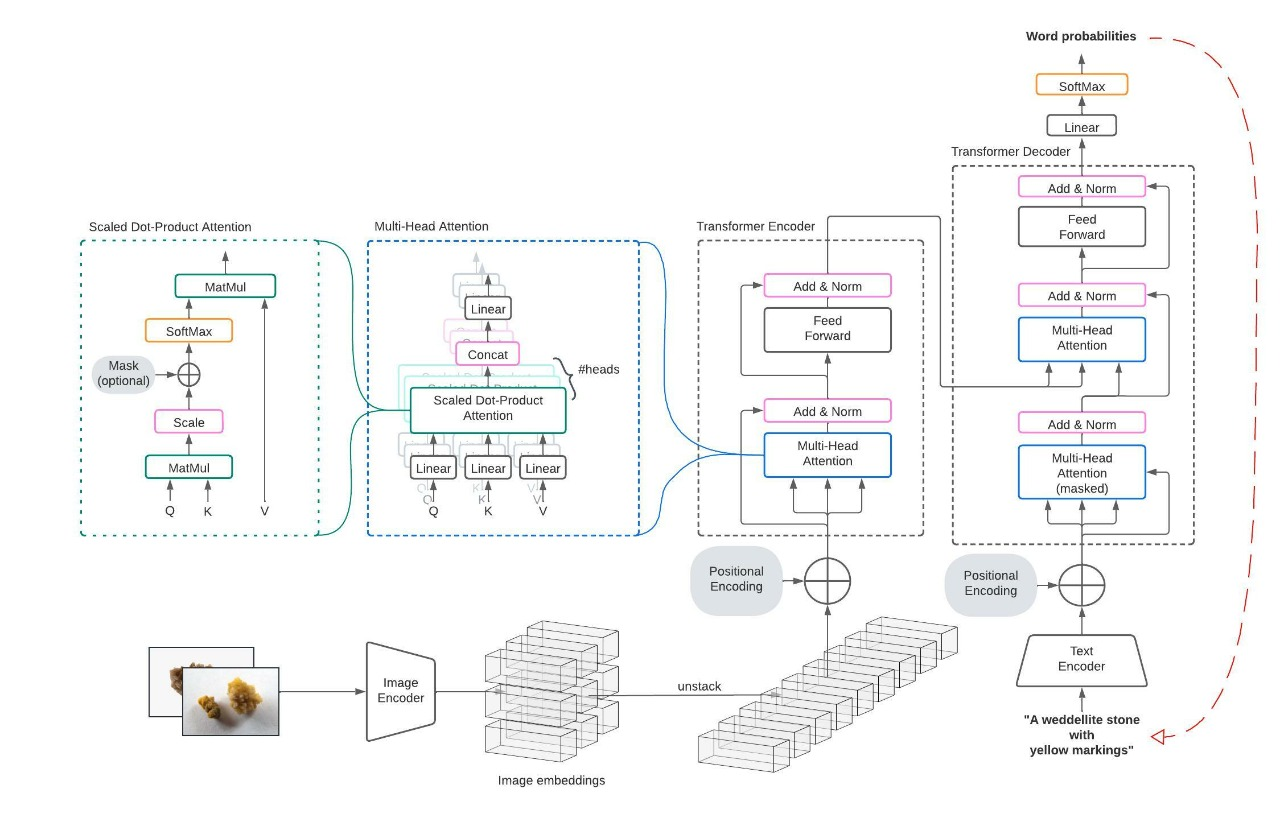

# Image encoder (model)

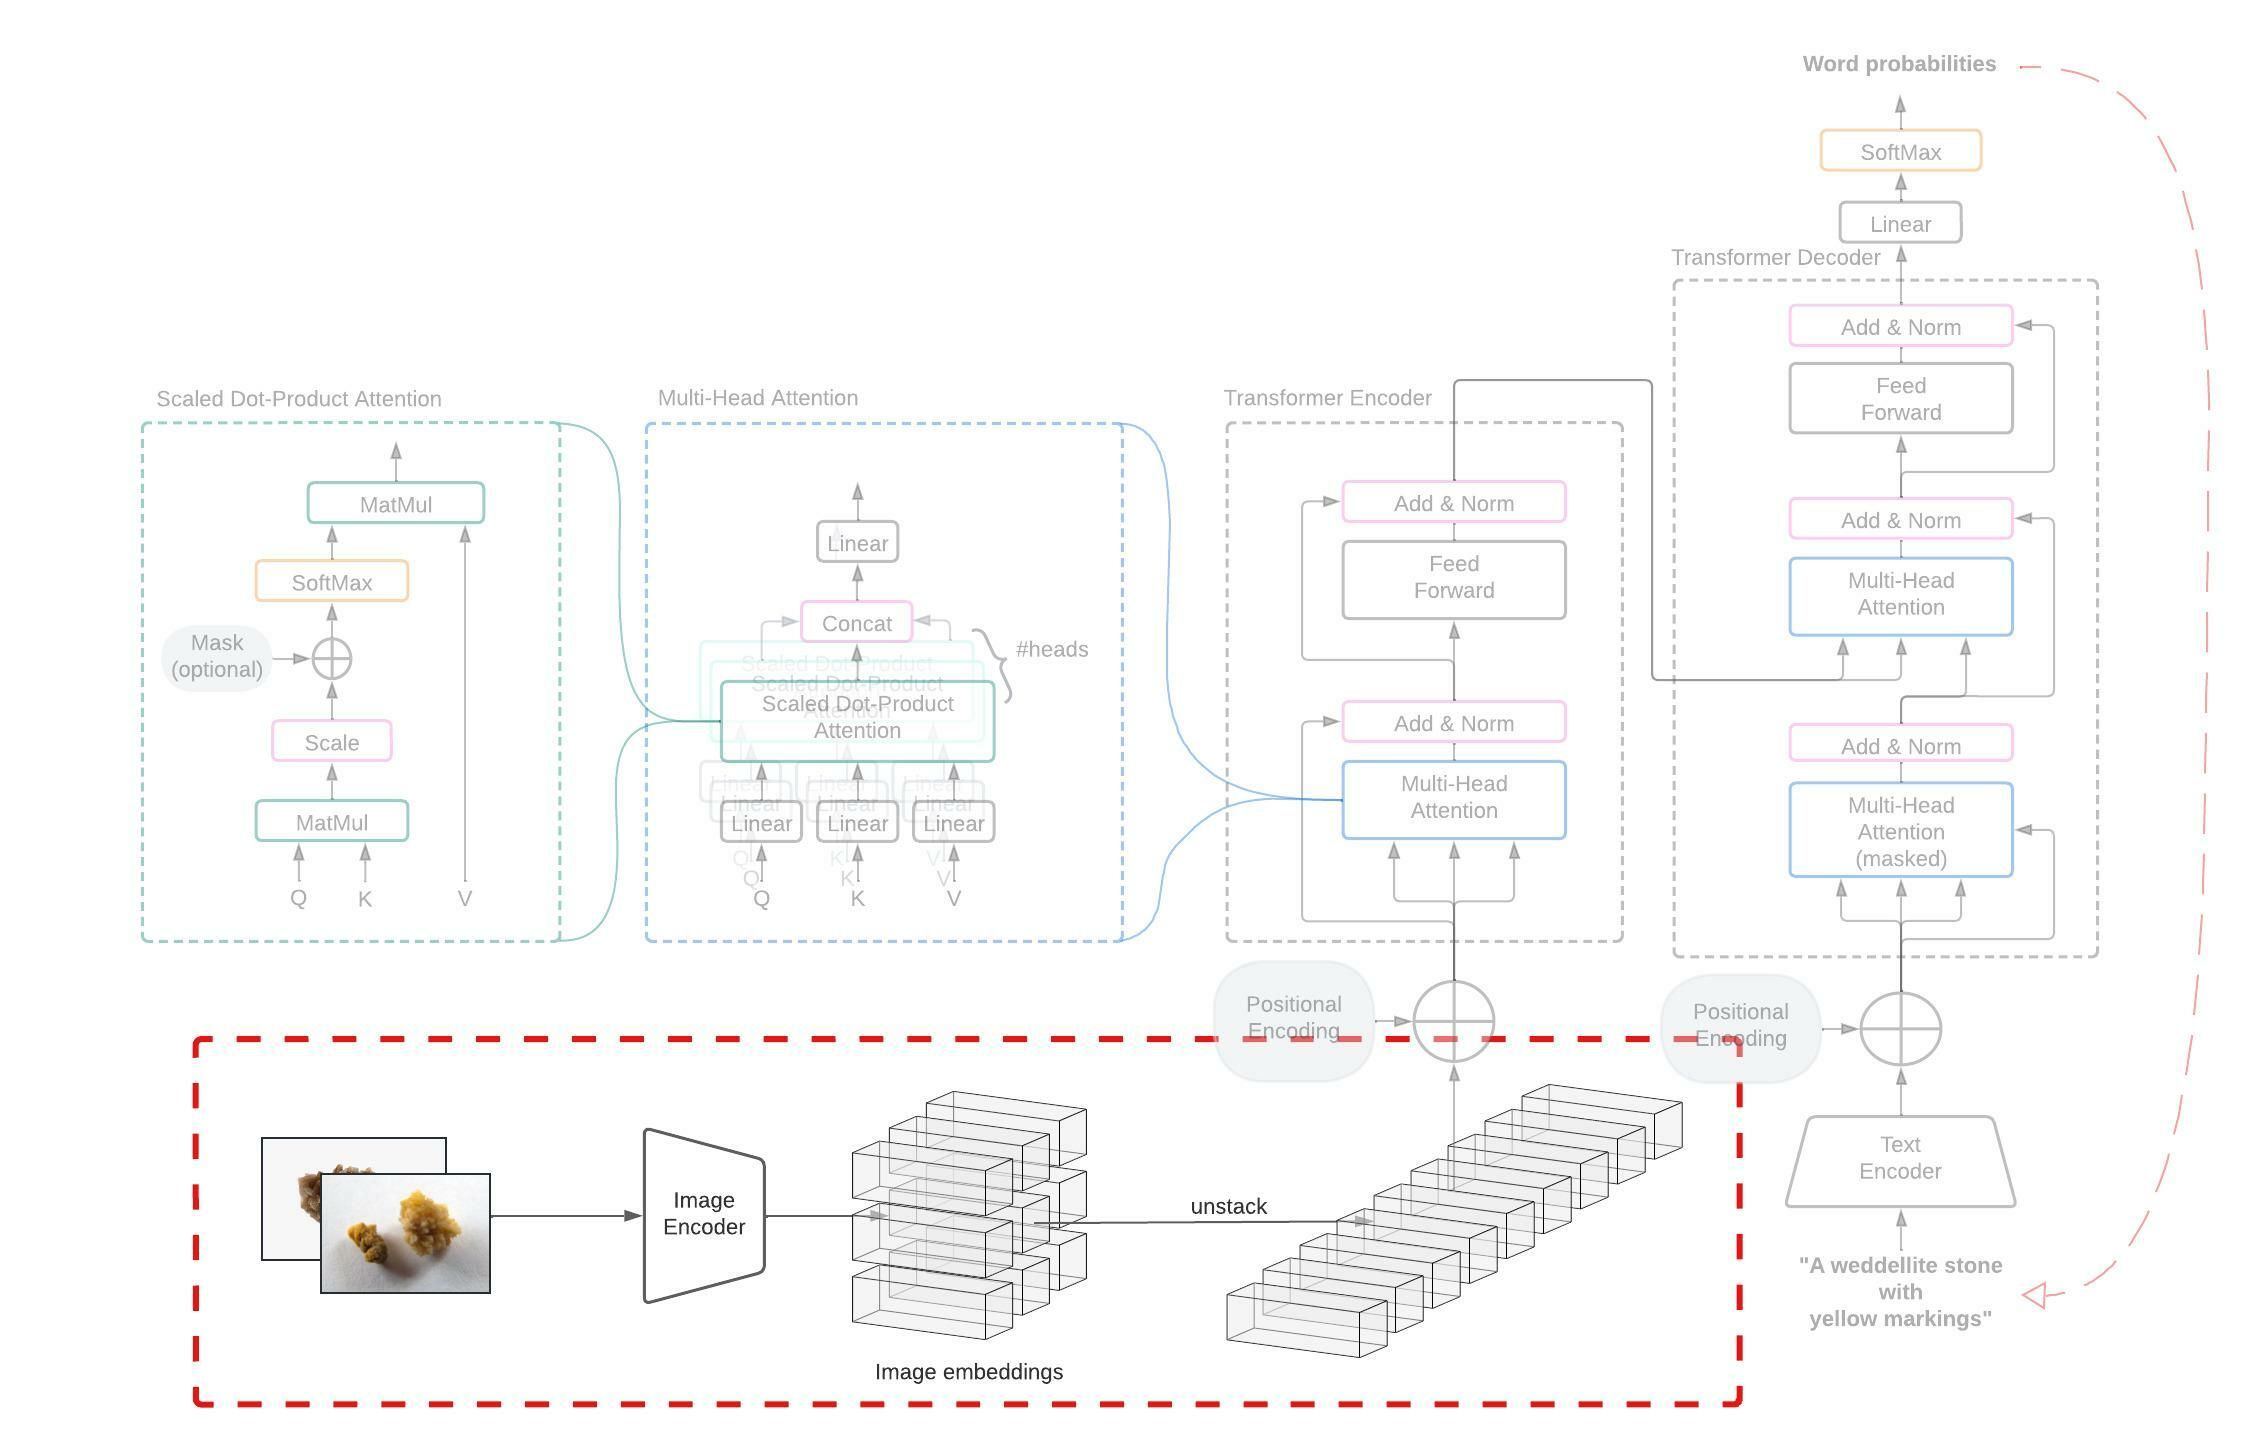

The input is a 299 by 299 image batch and the output are the image features corresponding to the last layer but they are flattened. 

In [ ]:
def make_image_encoder(IMAGE_SIZE=(299,299), backbone='efficientnetb0',trainable=False):
    inputs=tf.keras.Input(shape=(*IMAGE_SIZE,3))

    if backbone=='efficientnetb0':
    # Notice that the images must be in float formate (299,299,3) and go from 0 to 255
        print('input images must be floats from 0 to 255 and have (299,299,3) format.') 
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(
            input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
        )
    if backbone=='resnet50':
    # Special preprocessing needed
     
        base_model=tf.keras.applications.resnet50.ResNet50(
            input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
        )
    
    base_model.trainable = trainable
    base_model_out = base_model.output
    base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out, name='image_encoder')
    return cnn_model


Example: 

In [ ]:
model=make_image_encoder((299,299), backbone='resnet50',trainable=False)

2022-11-06 01:06:32.922493: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-06 01:06:32.922546: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-8-20221025-075908): /proc/driver/nvidia/version does not exist
2022-11-06 01:06:32.923960: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Transformer Encoder Block (Layer )

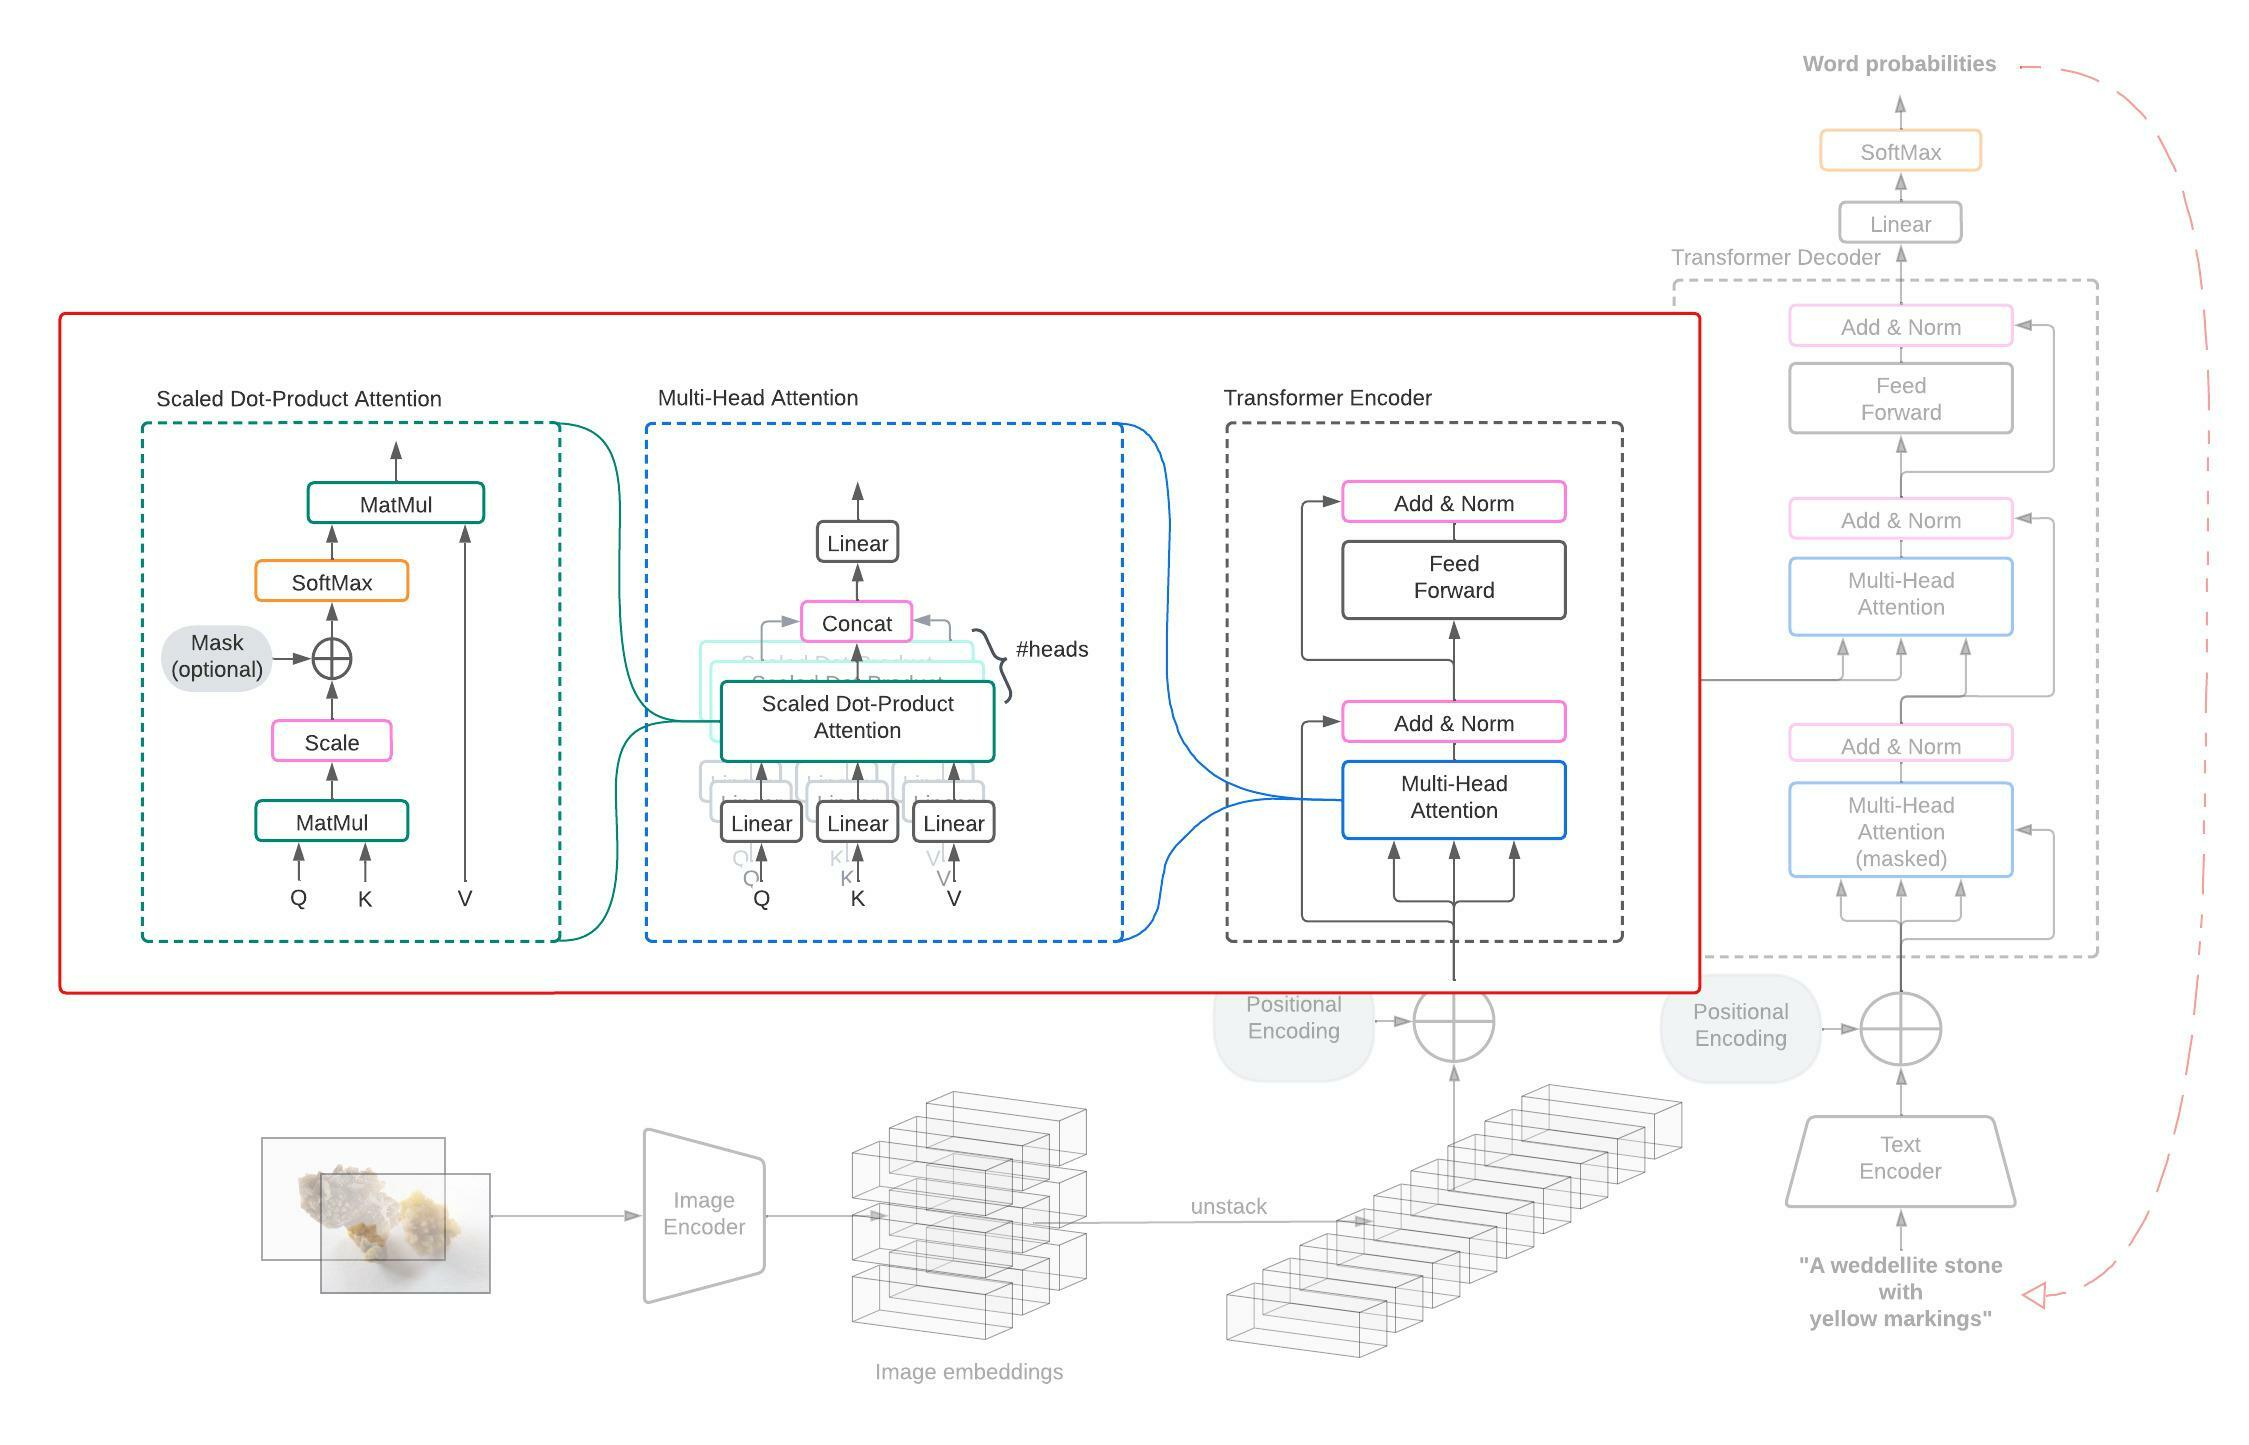

This encoder block will take convolutional vectors corresponding to different areas of the image and transform them into a sequence of values for text queries. It follows the transformer architecture: 







In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, seq_len, embedding_dim, num_heads,dropout,**kwargs):
        super().__init__(**kwargs)
            

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout)
        # Mha Q:(T,k_dim), K: (S,key_dim), V (S, v_dim)
        # T=Sequence length of query, S=Number of values to attend to. 
        # notice that there  is one key per value to attend to, meaning 
        # there are S values and S keys. 
        # The operation QxT'xV is performed, which yields dimensions
        # (T x k_dim) x (k_dim x v_dim) = T x v_dim
        # however then the result is projected 
        # back to k_dim size to yield (T x k_dim) result.  
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim, activation='relu'),  # (batch_size, seq_len, dff)
            tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
        ])
      
        self.norm_input = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=True,mask=None):

        x=self.norm_input(x)
        attn_output, att = self.mha(query=x, 
                                  value=x, 
                                  key=x, 
                                  return_attention_scores=True)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        output_dict={'embeddings':out2,'attentions':att}
        return output_dict



## Transformer Encoder Block Layer Access to Attention
Simulating an input of 64 batch size with sequences of 16 patches each and 100 features in the resulting embeddings

In [ ]:
t_encoder=TransformerEncoder(seq_len=16,embedding_dim=100,num_heads=3,dropout=0.1)
inputs=np.random.randint(0,100,(64,16,100)).astype(float)
t_encoder(inputs)

{'embeddings': <tf.Tensor: shape=(64, 16, 100), dtype=float32, numpy=
 array([[[-6.45343840e-01,  3.66900682e-01,  1.45785582e+00, ...,
           1.83656681e+00,  1.17824030e+00,  1.02249575e+00],
         [-1.64081955e+00,  2.27175623e-01, -4.60297614e-01, ...,
           2.02390194e+00,  1.23375547e+00,  4.04936433e-01],
         [-6.84482932e-01,  1.91069022e-03, -1.09190345e+00, ...,
          -2.69937575e-01, -8.25233519e-01,  8.06801498e-01],
         ...,
         [ 8.86879086e-01,  1.30630687e-01,  1.31648159e+00, ...,
          -1.69045210e+00,  9.24720228e-01, -6.04665995e-01],
         [-5.11269510e-01, -2.53667086e-02,  6.38514757e-01, ...,
           1.33987916e+00, -7.10608482e-01, -2.90567696e-01],
         [ 2.62808919e-01,  1.81790516e-01, -3.70428562e-01, ...,
           2.82654703e-01, -6.77329779e-01,  2.82059371e-01]],
 
        [[ 9.64661300e-01, -1.71084017e-01,  1.38677859e+00, ...,
          -6.50526464e-01,  1.23262331e-02, -1.24698639e+00],
         [ 1.1564

# Text encoder (layer within class)
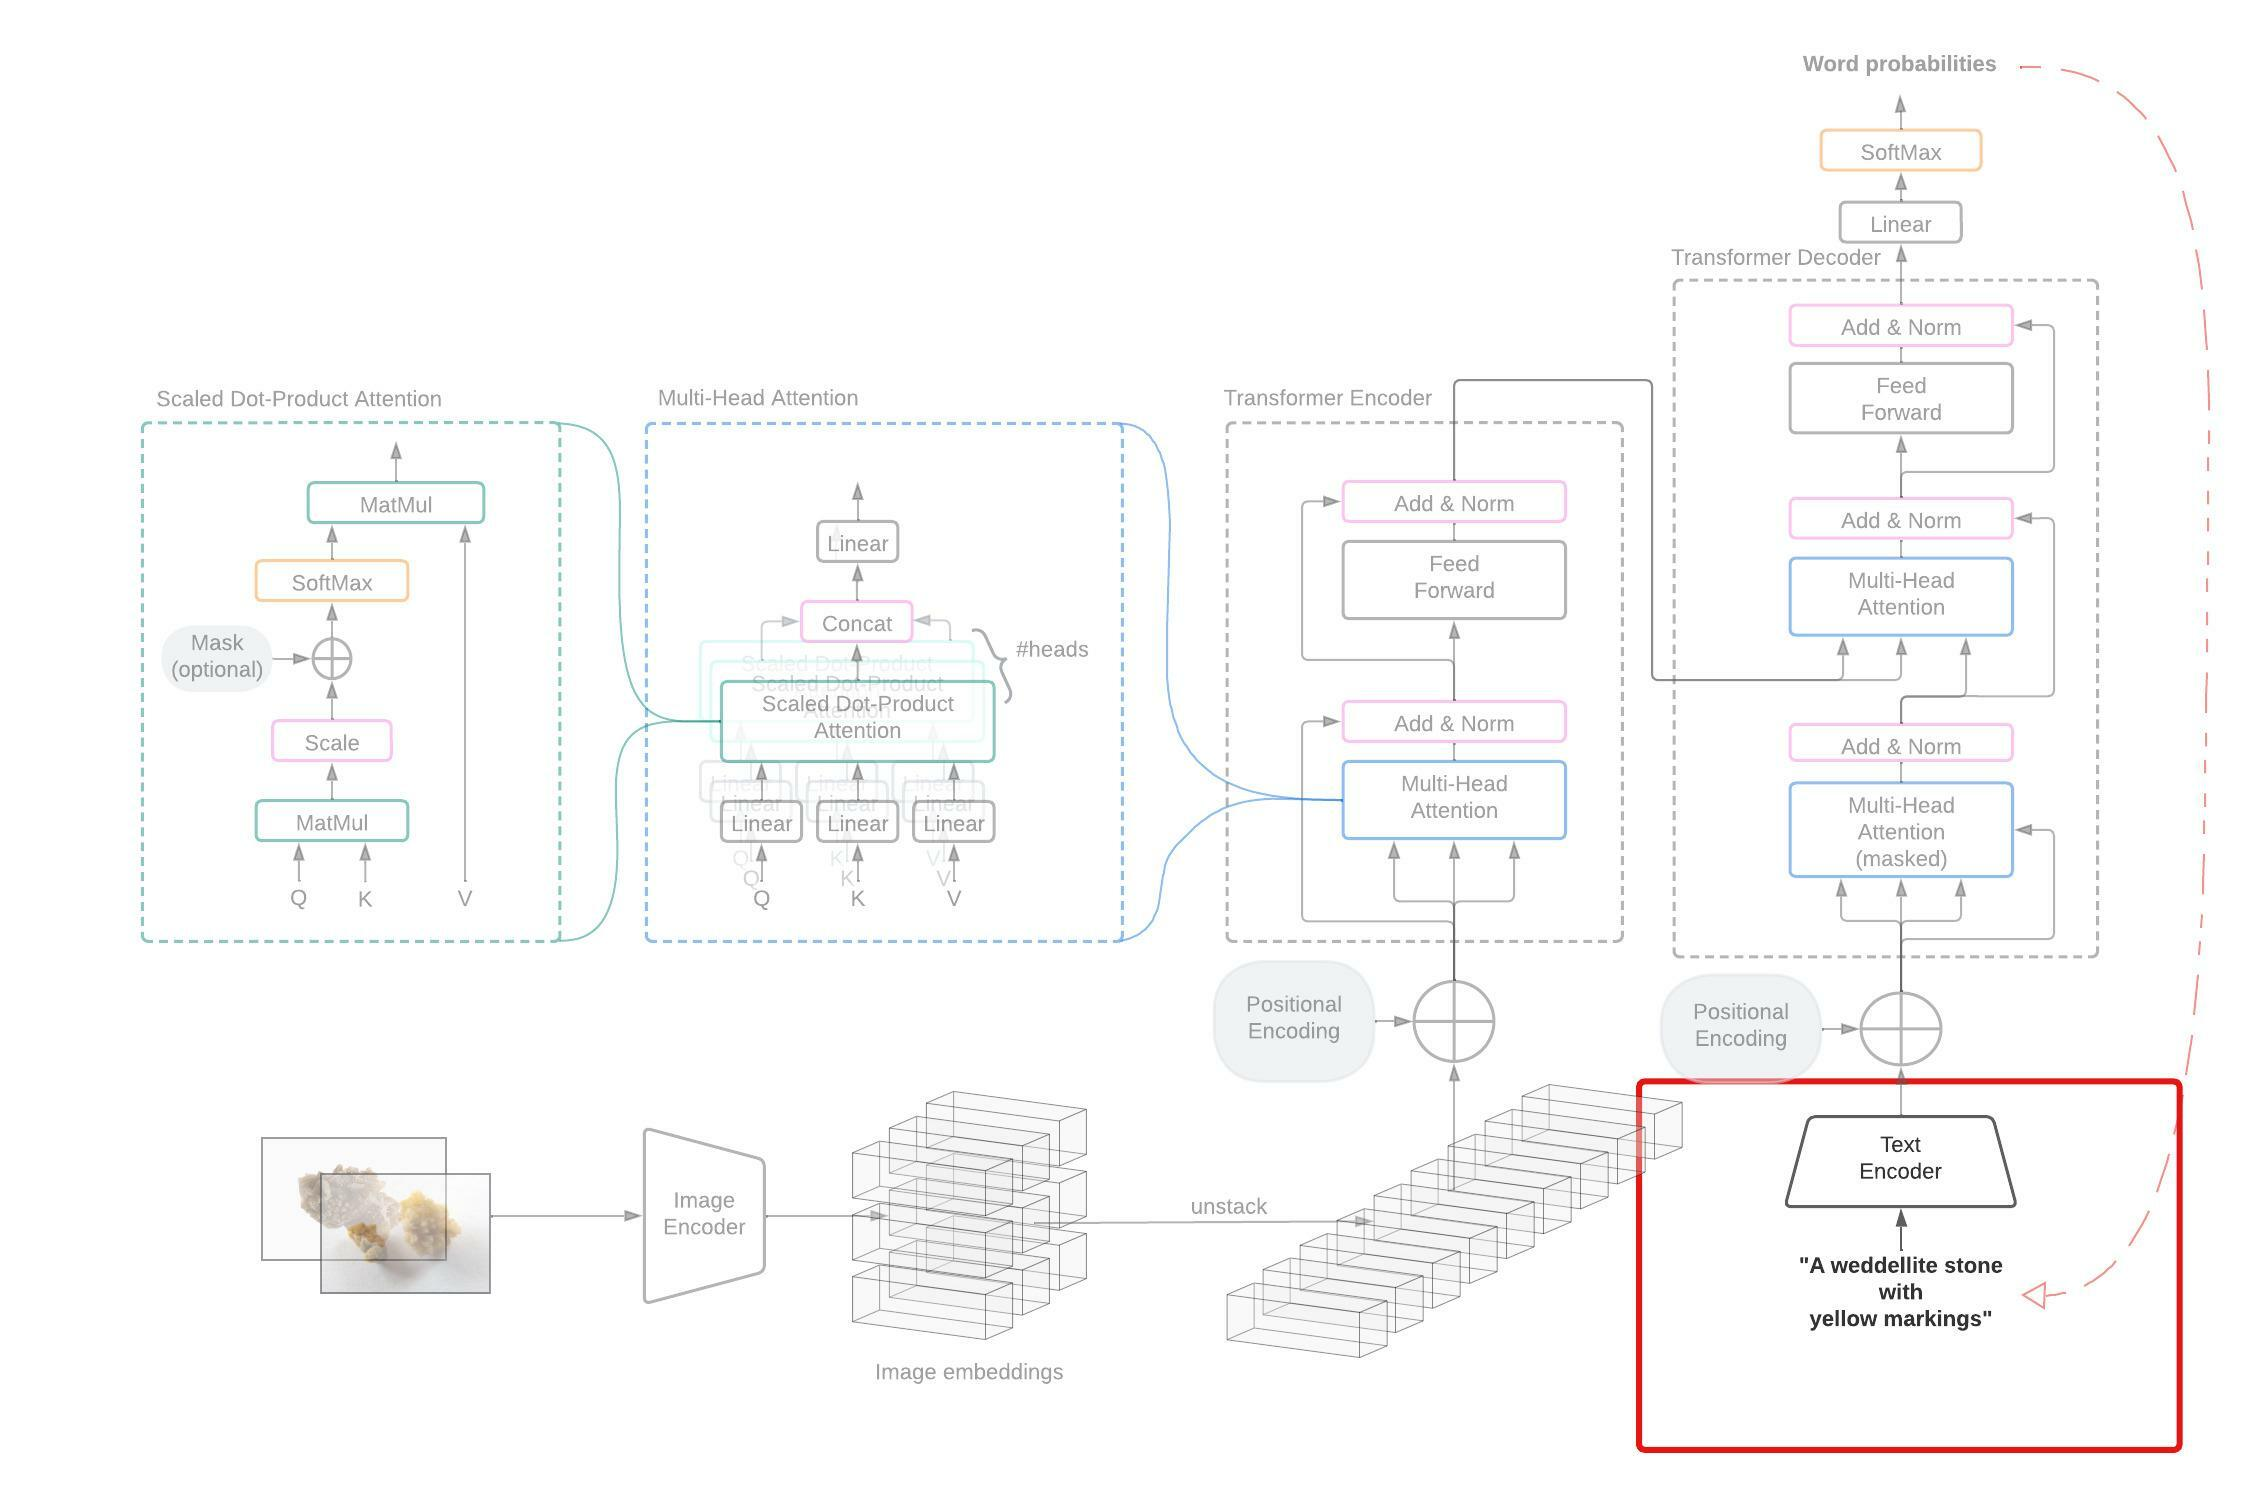









We opted to implement a class to gain access to the specific tokenizer of the text encoder (which is different for bert, clinical_bert, etc as well as the masking function). The class template must have the following methods: 
1. .mask(tokens)
2. .tokenize(text)
3. .encode(tokens)
The core layer: 
    This layer takes a string and returns vectorized string. There are several options for this one. 

In [ ]:
class TextEncoder(object):
    """A text encoder and associated objects for modular implementations.

    The class is to be used within larger architectures such as the clip
    pretraining module or the captioning transformer. The class includes
    the tokenizer as well as encoding functions. 
    
    Usage: 
        encoder=TextEncoder()
        tokens=encoder.tokenizer(df)
        embeddings=encoder.encode(tokens)

    Attributes:
        
        seq_len (int): The sequence length for the outputs. 
        embedding_dim (int): The embedding dimensions. 
        projection_trainable (bool): Whether the projection head of the 
            model is trainable or not. 
        backbone_trainable (bool): Whether the backbone of the model is 
            trainable or not. 
        dropout (float): Dropout rate. 
        tokenizer(function): A tokenizer object built uisng seq_len attribute.  
        encoder(keras_model): An encoder model built on the previous attributes, 
            (seq_len,embedding_dim,projection_trainable and backbone trainable).
        start_token(str): Start token. 
        end_token(str:): End token.
        
        Start and end tokens are added to the begnning and end of captions. 
        
        
    """
    def __init__(self,seq_len=100,embedding_dim=512,projection_trainable=False,
                 backbone_trainable=False,dropout=0.1):
        """Initializes the text encoder to the default values. Builds the encoders
           and tokenizers. 
           
            Args:
                
                seq_len (int): The sequence length for the outputs. 
                embedding_dim (int): The embedding dimensions. 
                projection_trainable (bool): Whether the projection head of the 
                    model is trainable or not. 
                backbone_trainable (bool): Whether the backbone of the model is 
                    trainable or not. 
                dropout(float,optional): The dropout rate. 
               
        """
        self.seq_len=seq_len
        self.embedding_dim=embedding_dim
        self.projection_trainable=projection_trainable
        self.backbone_trainable=backbone_trainable
        self.dropout=dropout
        
        self.tokenizer=self.build_tokenizer()
        self.encoder=self.build_encoder()
    @ property
    def vocab(self):
        print('vocab property not yet implemented')
        vocab=None
        return vocab


    def build_tokenizer(self):
        """Builds the tokenizer according to the class attributes.
        
        Some subclasses may need access to the training data to build the tokenizer. 
        """
        print('build_tokenizer method called but method not implemented.')
        return None
    
    def build_encoder(self):
        """Build the encoder. 
        
        The encoder must take sequences of tokens and return 
        embeddings of size 'self.emb_dim'
        """
        print('build_encoder method called but method not implemented.')
        return None
    
    def tokenize(self,texts):
        """Apply preprocessing and tokenizes the texts.
        
        Args: 
            texts(tensor): Tensor of shape (batch_size,None) of strings. 
            
        Returns: 
            tokens(tensor):Tensor of shape (batch_size,seq_len) of token keys.
        """
       
        
        return self.tokenizer(texts)
        
    def encode(self,tokens,**kwargs):
        """Encode the tokens into vectors of size 'self.embedding_dim'
        Args: 
            tokens(tensor of ints): A tensor of shape (batch_size,self.seq_len)
                containing the token keys. 
        Returns: 
            embeddings(tensor of floats): A tensor of shape 
                (batch_size, self.seq_len, self.embedding_dim)
        """
        return self.encoder(tokens,**kwargs)
        
    def tokenize_and_encode(self,texts):
        """Apply the tokenizer and then the encoder to a sequence of texts. 
        
        Args:
            texts(iterable): A sequence of strings. 
        Returns: 
            embeddings(tensor): A tensor of shape (batch_size,slf.seq_len,self.embedding_dim)
            that contains the embedding representation of the texts. 
            
        """
        tokens=self.tokenize(texts)
        embeddings=self.encode(tokens)
        
        return embeddings
    
    def mask(self,tokens):
        """Mask 0 tokens
        Args: 
            
        """
        return tf.math.not_equal(tokens, 0)
        

## Option1: Embedding Matrix text encoder (class) 

In [ ]:
class MatrixTextEncoder(TextEncoder):
    """Children of TextEncoder. Embedding matrix text encoder. 
        
    A simple text encoder composed by a tokenizer and an embedding 
    matrix. 
        
        
        
    """
    def __init__(self,tokenizer_data,**kwargs):
        """Initializes the text encoder to the default values. Builds the encoders
           and tokenizers. 
           
        Args:
            tokenizer_data(iterable): A list or array of texts on which to adapt the 
                tokenizer. 
            embedding_dim (int,optional): The embedding dimensions. Defaults to 512 
            projection_trainable (bool,optional): Whether the projection head of the 
                model is trainable or not. Defaults to False. 
            backbone_trainable (bool,optional): Whether the backbone of the model is 
                trainable or not. Defaults to False. 

        """
        self.tokenizer_data=tokenizer_data
        self.backbone=None
        self.start_token='<start>'
        self.end_token='<end>'
            
        
        # The super class is called at last because I am overriding the build_tokenizer method
        # which now requires self.tokenizer_data so we need to instantiate it first and then 
        # build the rest of attributes from super. 
        super().__init__(**kwargs)
        
    @property
    def vocabulary_size(self):
        "str: The vocabulary size of the tokenizer including OOV token"
        return self.tokenizer.vocabulary_size()
    @property
    def vocabulary(self):
        return self.tokenizer.get_vocabulary()
    @property
    def vocabulary_dict(self):
        dictionary=dict(zip(range(len(self.vocabulary)),self.vocabulary))
        return dictionary
    
    def standarize(self, input_string):
        strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
        strip_chars = strip_chars.replace("<", "")
        strip_chars = strip_chars.replace(">", "")
        lowercase = tf.strings.lower(input_string)
        final_string =tf.strings.regex_replace(lowercase, 
                                                 "[%s]" % re.escape(strip_chars), "")
        return final_string
        
    def build_tokenizer(self):
        """ Builds and adapts the tokenizer according to the class attributes"""
        tokenizer=tf.keras.layers.TextVectorization(
        max_tokens=None,
        standardize=self.standarize,
        split='whitespace',
        ngrams=None,
        output_mode='int',
        output_sequence_length=self.seq_len, # Impotant to fit the ammount of characters in the string. 
        pad_to_max_tokens=False,
        vocabulary=None,
        idf_weights=None,
        sparse=False,
        ragged=False,
        name='Matrix_Text_Encoder_Vectorizer'
        )
        

        tokenizer.adapt(self.tokenizer_data)
        return tokenizer
    def build_encoder(self):
        """
        Builds a keras functional model text encoder based on the class
        attributes. 
        """
        input_tokens=tf.keras.Input(shape=[None])
        embedding_matrix= tf.keras.layers.Embedding(
            input_dim=self.tokenizer.vocabulary_size(),
            output_dim=self.embedding_dim,
            embeddings_initializer='uniform',
            embeddings_regularizer=None,
            activity_regularizer=None,
            embeddings_constraint=None,
            mask_zero=False,
            input_length=None,
        )

        output_embeddings=embedding_matrix(input_tokens)
        model=tf.keras.Model(inputs=input_tokens,
                             outputs=output_embeddings,name='Matrix_Text_Encoder')
        if not self.projection_trainable:
            for layer in model.layers:
                layer.trainable=False
        return model
    
        
        
        

test

In [ ]:
# data_pipeline=make_pipeline('../data/intermediate/inter_medpix.csv',
#                   image_size=(299, 299),downscale=True,
#                   shuffle=True,
#                   seed=1,fractions=[0.70,0.05,0.05]) 
# encoder_bundle=MatrixTextEncoder(data_pipeline['captioning']['train_captions'])
# data=data_pipeline['captioning']['train_captions'][0:10]
# tokens=encoder_bundle.tokenize(data)
# embeddings=encoder_bundle.tokenize_and_encode(data)
# masks=encoder_bundle.mask(tokens)
# image_input=tf.keras.Input(shape=(299,299,3),name='image')
# text_input= tf.keras.Input(shape=(),dtype=tf.dtypes.string,name='text')
# encoder=encoder_bundle.tokenize_and_encode
# embeddings=encoder(text_input)
# model=tf.keras.Model(inputs=[image_input,text_input],outputs=embeddings)
# emb=model.predict(data_pipeline['captioning']['train'].batch(5).take(3))
# model.summary(expand_nested=True)


## Option 2: backbone based encoder (class) under development

In [ ]:
# class BertTextEncoder(TextEncoder):
#     """Children of TextEncoder. Bert based text encoder. 
        
#     Bert preprocessor, bert encoding and a projection head. 
        
        
#     Attributes:
#         seq_len (int): The sequence length for the outputs. 
#         embedding_dim (int): The embedding dimensions. 
#         projection_trainable (bool): Whether the projection head of the 
#             model is trainable or not. 
#         backbone_trainable (bool): Whether the backbone of the model is 
#             trainable or not. 
#         tokenizer(function): The bert preprocessor layer.   
#         encoder(keras_model): An encoder model built on the previous attributes, 
#             (seq_len,embedding_dim,projection_trainable and backbone trainable).
#         backbone(keras layer): The bert layer. 
#         num_layers(int): Number of projection layers used in projection head. 
        
#     """ 
   
#     def __init__(self,num_layers=1,**kwargs):
#         """Initializes the text encoder to the default values. Builds the 
#         encoders and tokenizers. 
           
#         Args:
#             num_layers(int,optional): Number of layers to use for projection 
#                 head. 
#             seq_len (int,optional): The sequence length for the outputs. 
#                 Defaults to 100 
#             embedding_dim (int,optional): The embedding dimensions. Defaults to 
#                 512. 
#             projection_trainable (bool,optional): Whether the projection head of
#                 the model is trainable or not. Defaults to False. 
#             backbone_trainable (bool,optional): Whether the backbone of the 
#                 model is trainable or not. Defaults to False. 
#             dropout (float,optional): Dropout rate. 

#         """
#         self.num_layers=num_layers
#         if 'seq_len' in kwargs:
#             print('Sequence length provided but'+ 
#                   'sequence length is fixed for bert encoder to 128. It will'+
#                   ' default to 128')
#         # The super class is called at last because I am overriding the build_tokenizer method
#         # which now requires self.tokenizer_data so we need to instantiate it first and then 
#         # build the rest of attributes from super. 
#         super().__init__(seq_len=128,**kwargs) # sequence length is fixed to 128 for bert
        
        
#     @property
#     def vocabulary_size(self):
#         "str: The vocabulary size of the tokenizer including OOV token"
#         self.tokenizer.vocabulary_size()
        
#     def build_tokenizer(self):
#         """Import the tokenizer from the bert_preprocessor in tensorflow hub."""
        
#         preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
#         bert_preprocessor=hub.KerasLayer(preprocessor_url,name='bert_preprocessor')
        
#         return bert_preprocessor
    
#     def tokenize(self,texts):

#         """Apply preprocessing and tokenize the texts.
        
#         Args: 
#             texts(tensor): Tensor of shape (batch_size,None) of strings. 
#             preprocessor(function, optional): A function to apply to every 
#                 text before going through the tokenizer. 
#         Returns: 
#             tokens(tensor):Tensor of shape (batch_size,seq_len) of token keys. 
#         """

#         # The bert preprocessor yields a dictionary. 
#         preprocessor_output=self.tokenizer(texts)
        
#         # Take tokens out of dictionary and return them
#         tokens=preprocessor_output['input_word_ids']
        
#         return tokens
    
#     def build_encoder(self):
#         """
#         Builds a model that uses a bert encoder followed by a projection head.
        
#         The inputs to the model are the tokens (word_ids)
        
#         """
    
#         bert_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
#         bert=hub.KerasLayer(bert_url,name='bert')
#         self.backbone=bert

#         bert.trainable=self.backbone_trainable

#         # Building functional model
#         # Since pert expects a dictionary, we must first fabricate 
#         # the parameters required for bert to take the input: 
#         # 'input_word_ids', 'input_type_ids', 'input_mask'
        
        
#         token_inputs=tf.cast(tf.keras.Input(shape=(self.seq_len),name='tokens'),
#                              tf.dtypes.int32) 
#         zeros=np.zeros(shape=(1,self.seq_len)).astype('int32')
#         mask=tf.cast(self.mask(token_inputs),tf.dtypes.int32)
#         bert_input={'input_word_ids':token_inputs, 
#                     'input_type_ids':tf.constant(zeros),
#                     'input_mask':mask}
        
#         x=bert(bert_input)['sequence_output']
#         embeddings=self.make_projection_head()(x)

#         return tf.keras.Model(inputs=token_inputs,outputs=embeddings,name='text_encoder')      
    
#     def make_projection_head(self):
#         """
#         Make a projection head. 
        
#         The projection head is a fully connected network that projects the 
#         embeddings from the backbone output dimension into a desired dimension.
        
#         Args: 
#             backbone_embed
        
#         """
#         inputs=keras.Input(shape=(self.seq_len,768)) # Takes dimension of backbone output
#         projection=layers.Dense(self.embedding_dim)(inputs)

#         for i in range(self.num_layers): 
#             x = tf.nn.gelu(projection)
#             x = layers.Dense(self.embedding_dim)(x)
#             x = layers.Dropout(self.dropout)(x) 
#             x = layers.Add()([projection,x])
#             projection=layers.LayerNormalization()(x)

#         model=keras.Model(inputs=inputs,outputs=projection,name='projection_head')
#         if not self.projection_trainable:
#             for layer in model.layers: 
#                 layer.trainable=False


#         return model
        
        
        

In [ ]:
# preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
# bert_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# bert_preprocessor=hub.KerasLayer(preprocessor_url,name='bert_preprocessor')

In [ ]:
# bert_preprocessor(['text 1 this is','maybe text 2'])

In [ ]:
# text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# preprocessor = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder_inputs = preprocessor(text_input)

In [ ]:
# preprocessor = hub.load(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# # Step 1: tokenize batches of text inputs.
# text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)] # This SavedModel accepts up to 2 text inputs.
# tokenize = hub.KerasLayer(preprocessor.tokenize)
# tokenized_inputs = [tokenize(segment) for segment in text_inputs]

In [ ]:
# preprocessor.input_mask

Test

In [ ]:
# data_pipeline=make_pipeline('../data/intermediate/inter_medpix.csv',
#                   image_size=(299, 299),downscale=True,
#                   shuffle=True,
#                   seed=1,fractions=[0.70,0.15,0.15]) 
# encoder_bundle=BertTextEncoder()
# data=data_pipeline['captioning']['train_captions'][0:10]
# tokens=encoder_bundle.tokenize(data)
# embeddings=encoder_bundle.tokenize_and_encode(data)
# masks=encoder_bundle.mask(tokens)
# image_input=tf.keras.Input(shape=(299,299,3),name='image')
# text_input= tf.keras.Input(shape=(),dtype=tf.dtypes.string,name='text')
# encoder=encoder_bundle.tokenize_and_encode
# embeddings=encoder(text_input)
# model=tf.keras.Model(inputs=[image_input,text_input],outputs=embeddings)
# emb=model.predict(data_pipeline['captioning']['train'].batch(5).take(3))
# model.summary(expand_nested=True)

## Some functions to create encoders (deprecated)

In [ ]:
# def make_projection_head(embedding_dim, projection_size,num_layers,dropout_rate,name='projection_head',trainable=False):
#     input=keras.Input(shape=(embedding_dim))
#     projection=layers.Dense(projection_size)(input)

#     for i in range(num_layers): 
#         x = tf.nn.gelu(projection)
#         x = layers.Dense(projection_size)(x)
#         x = layers.Dropout(dropout_rate)(x) 
#         x = layers.Add()([projection,x])
#         projection=layers.LayerNormalization()(x)
    
#     model=keras.Model(inputs=input,outputs=projection,name=name)
#     if not trainable:
#         for layer in model.layers: 
#             layer.trainable=False
            
        
#     return model

In [ ]:

# def make_text_encoder_2(projection_size=64,
#                         backbone='bert',
#                         projection_layers=3,
#                         dropout_rate=0.2,
#                         bert_trainable=False,
#                         task='captioning'):
#     """
#     Make a text encoder that uses the BERT backbone. 
    
#     Args: 
#         projection_size (int): Size of the embedding
#         backbone (str): Currently only 'bert' is accepted. 
#         projection_layers(int): number of layers to add after the bert backbone. 
#         dropout_rate(float): dropout rate for projection layers. 
#         bert_trainable(bool): Whether the backbone is frozen (bert_trainable=False) or 
#             trainable (bert_trainable=True)
#         task(str): If 'captioning', shifts the text one token to the right and returns
#             both embeddings: indexes (0:-1) and (1:) under the keys 
#             'predictor_embeddings' and 'target_embeddings' as well as the tokens under the keys
#             'predictor_keys' and 'target_keys'. The mask applies 
            
#     Returns: 
#         model: Keras functional API model. 
#     """
#     if backbone=='bert':
#         # Importing Bert
#         preprocessor_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
#         bert_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
#         bert_preprocessor=hub.KerasLayer(preprocessor_url,name='bert_preprocessor')
#         bert=hub.KerasLayer(bert_url,name='bert')

#         # Set up Bert trainability
#         bert.trainable=bert_trainable

#         # Building functional model
#         inputs=tf.keras.Input(shape=(),dtype=tf.dtypes.string, name='text')
#         x=bert_preprocessor(inputs)
#         mask=x['input_mask']
#         tokens=x['input_word_ids']
#         x=bert(x)['pooled_output']
    

#     embeddings=make_projection_head(embedding_dim=x.shape[-1],
#                            projection_size=projection_size,
#                            num_layers=projection_layers,
#                            dropout_rate=dropout_rate,
#                            name='text_projection_head')(x)
    
    
    
#     outputs = {'embeddings':embeddings,
#                'mask':mask,
#                'tokens':tokens} 
#     return tf.keras.Model(inputs=inputs,outputs=outputs,name='text_encoder')


Testing

In [ ]:
# image_input=tf.keras.Input(shape=(299,299,3),name='image')
# text_input= tf.keras.Input(shape=(),dtype=tf.dtypes.string,name='text')
# encoder=make_text_encoder_2()
# embeddings=encoder(text_input)
# model=tf.keras.Model(inputs=[image_input,text_input],outputs=embeddings)
# emb=model.predict(data_pipeline['captioning']['train'].batch(5).take(3))
# model.summary(expand_nested=True)


# Positional embedding (layer)

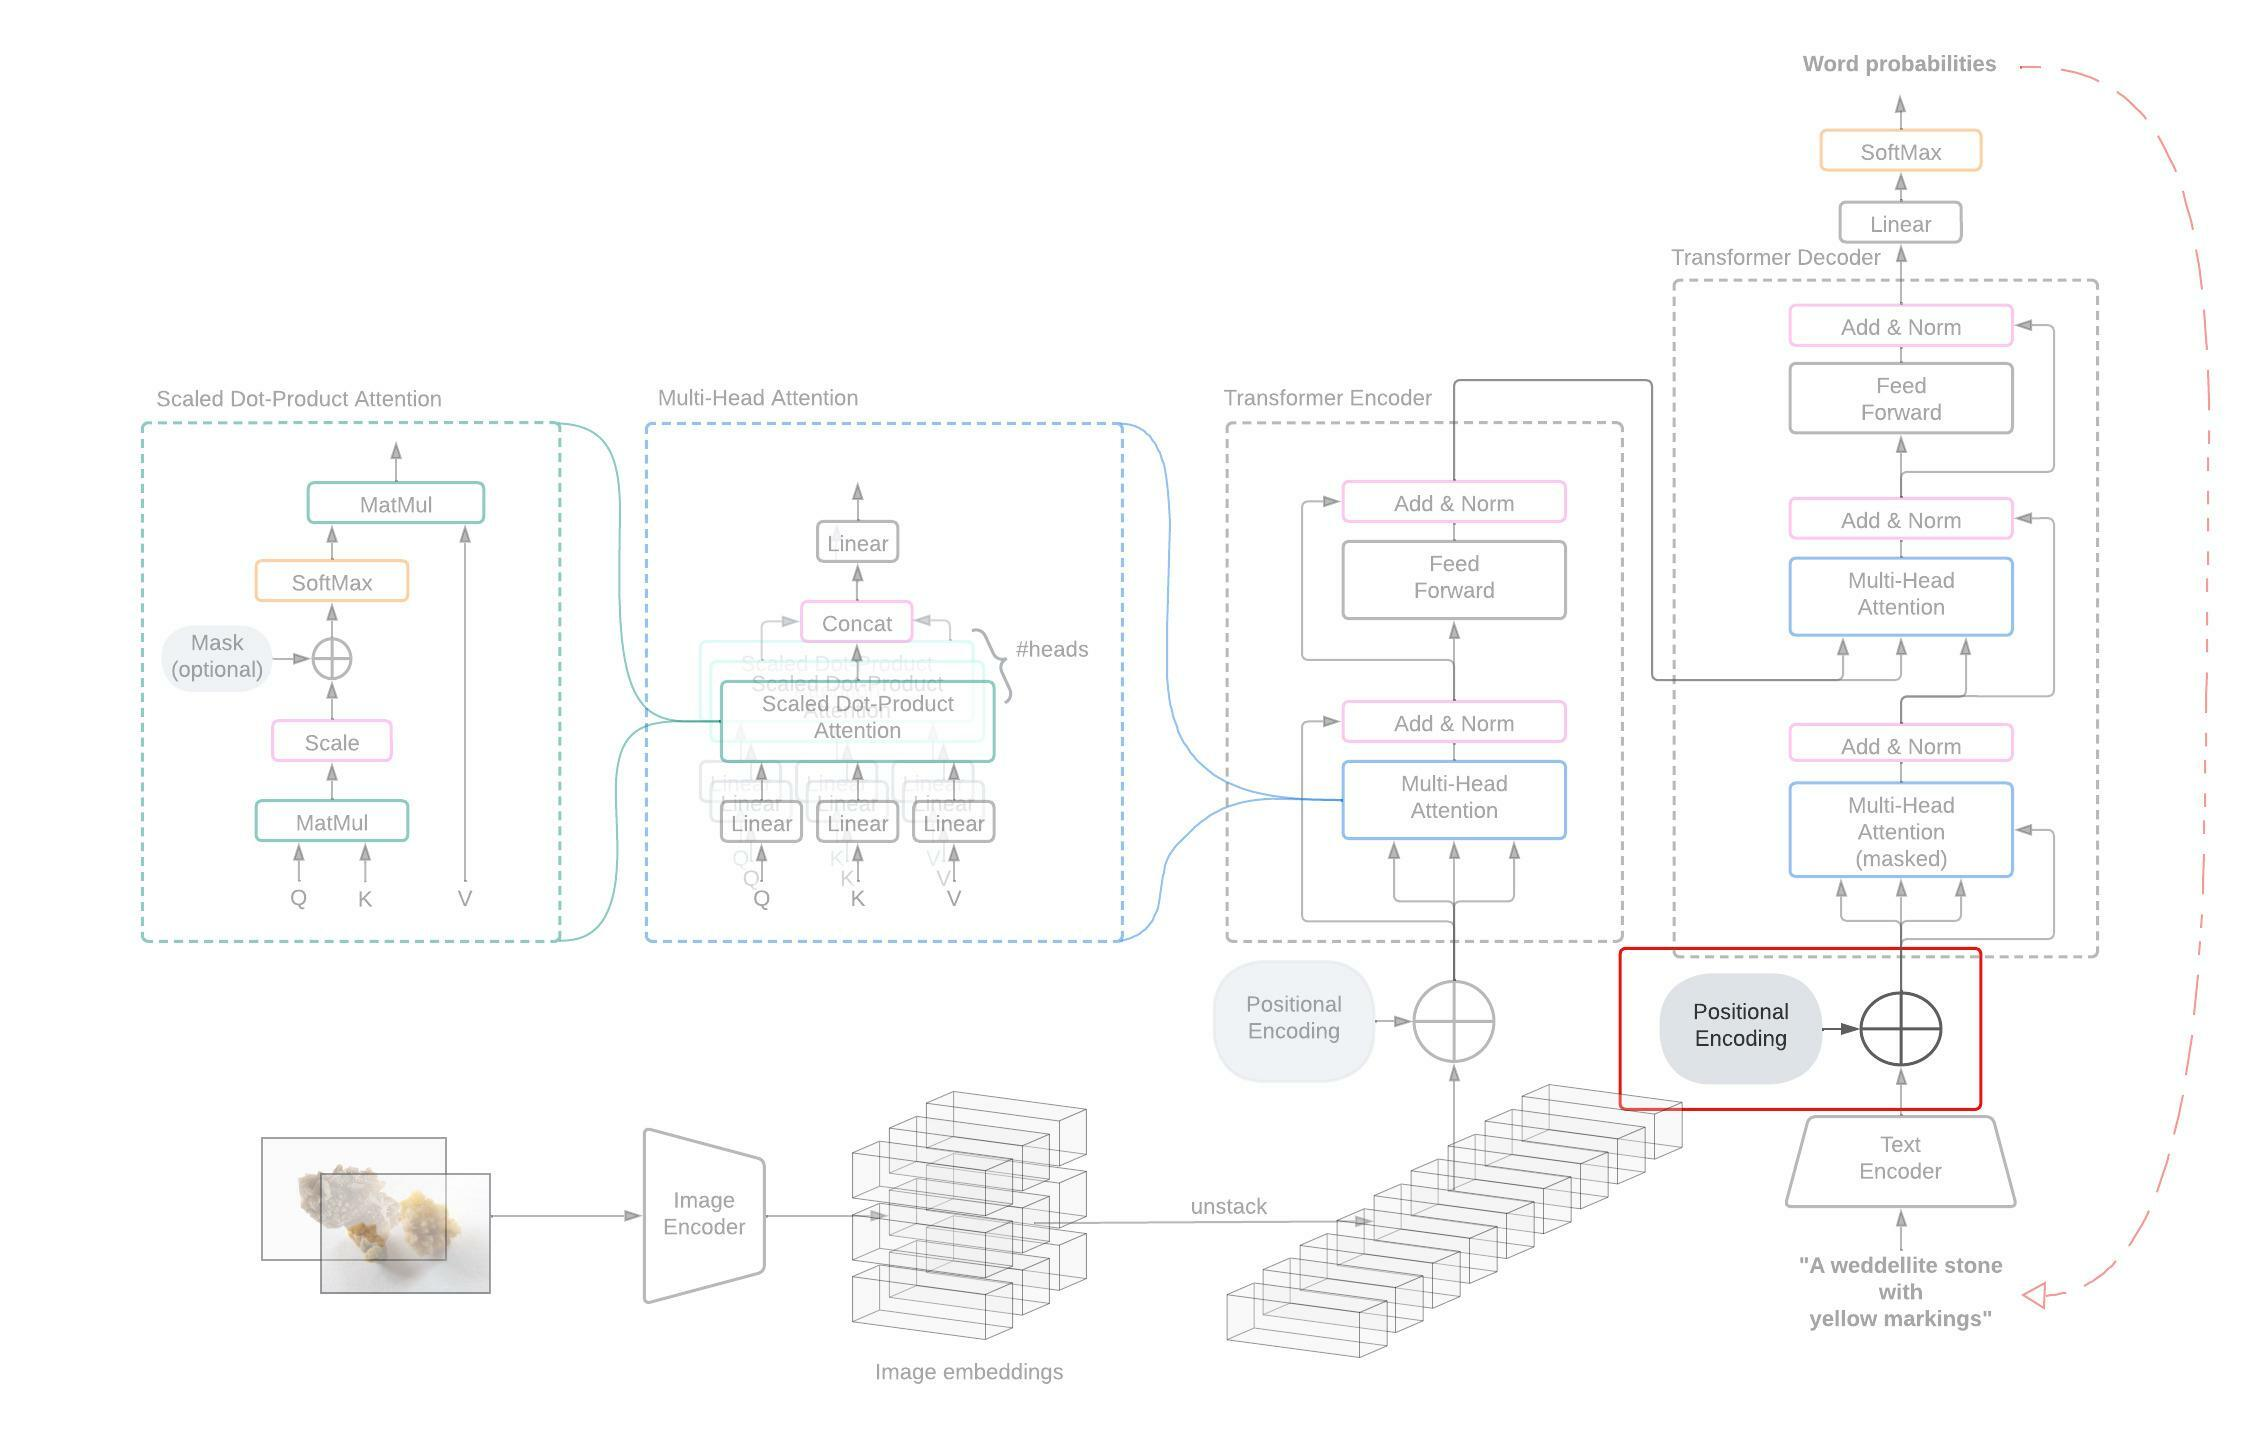


A custom layer that takes the text embeddings and learns a positional encoding to add to each index. 

In [ ]:
class AddLearntPositional(tf.keras.layers.Layer):
    def __init__(self,sequence_length,embedding_dim,**kwargs):
        super().__init__(**kwargs)
       
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embedding_dim
        )
        self.tok_emb_scale=tf.math.sqrt(tf.cast(embedding_dim,tf.float32))
        self.sequence_length=sequence_length

    def call(self,inputs):
        
        
        length = tf.shape(inputs)[-2] # Length of the sequence
        positions = tf.range(start=0, limit=length, delta=1) # Indexes of the positions
        embedded_positions = self.position_embeddings(positions)
        output_embedding=embedded_positions
        scaled_inputs=self.tok_emb_scale*inputs
        return output_embedding+inputs
    

In [ ]:
add_positional_embeddings=AddLearntPositional(100,128)
inputs=np.random.randint(1,10,(1,100,128)).astype(float)
add_positional_embeddings(inputs)

<tf.Tensor: shape=(1, 100, 128), dtype=float32, numpy=
array([[[2.045987 , 8.973555 , 1.0241169, ..., 1.0490073, 6.03094  ,
         1.0270164],
        [6.0236716, 0.9898825, 6.0261607, ..., 3.9884455, 4.9818087,
         1.0117418],
        [2.0331092, 3.0285537, 6.007943 , ..., 5.033249 , 1.0385566,
         5.0270343],
        ...,
        [1.9873235, 1.9932016, 4.0188823, ..., 4.02203  , 9.029957 ,
         1.9963512],
        [8.965522 , 8.043248 , 5.981201 , ..., 1.0497327, 0.9954907,
         0.9906971],
        [9.036889 , 7.9786406, 6.9735055, ..., 5.9776983, 6.9884853,
         3.956757 ]]], dtype=float32)>

# Transformer decoder (layer)

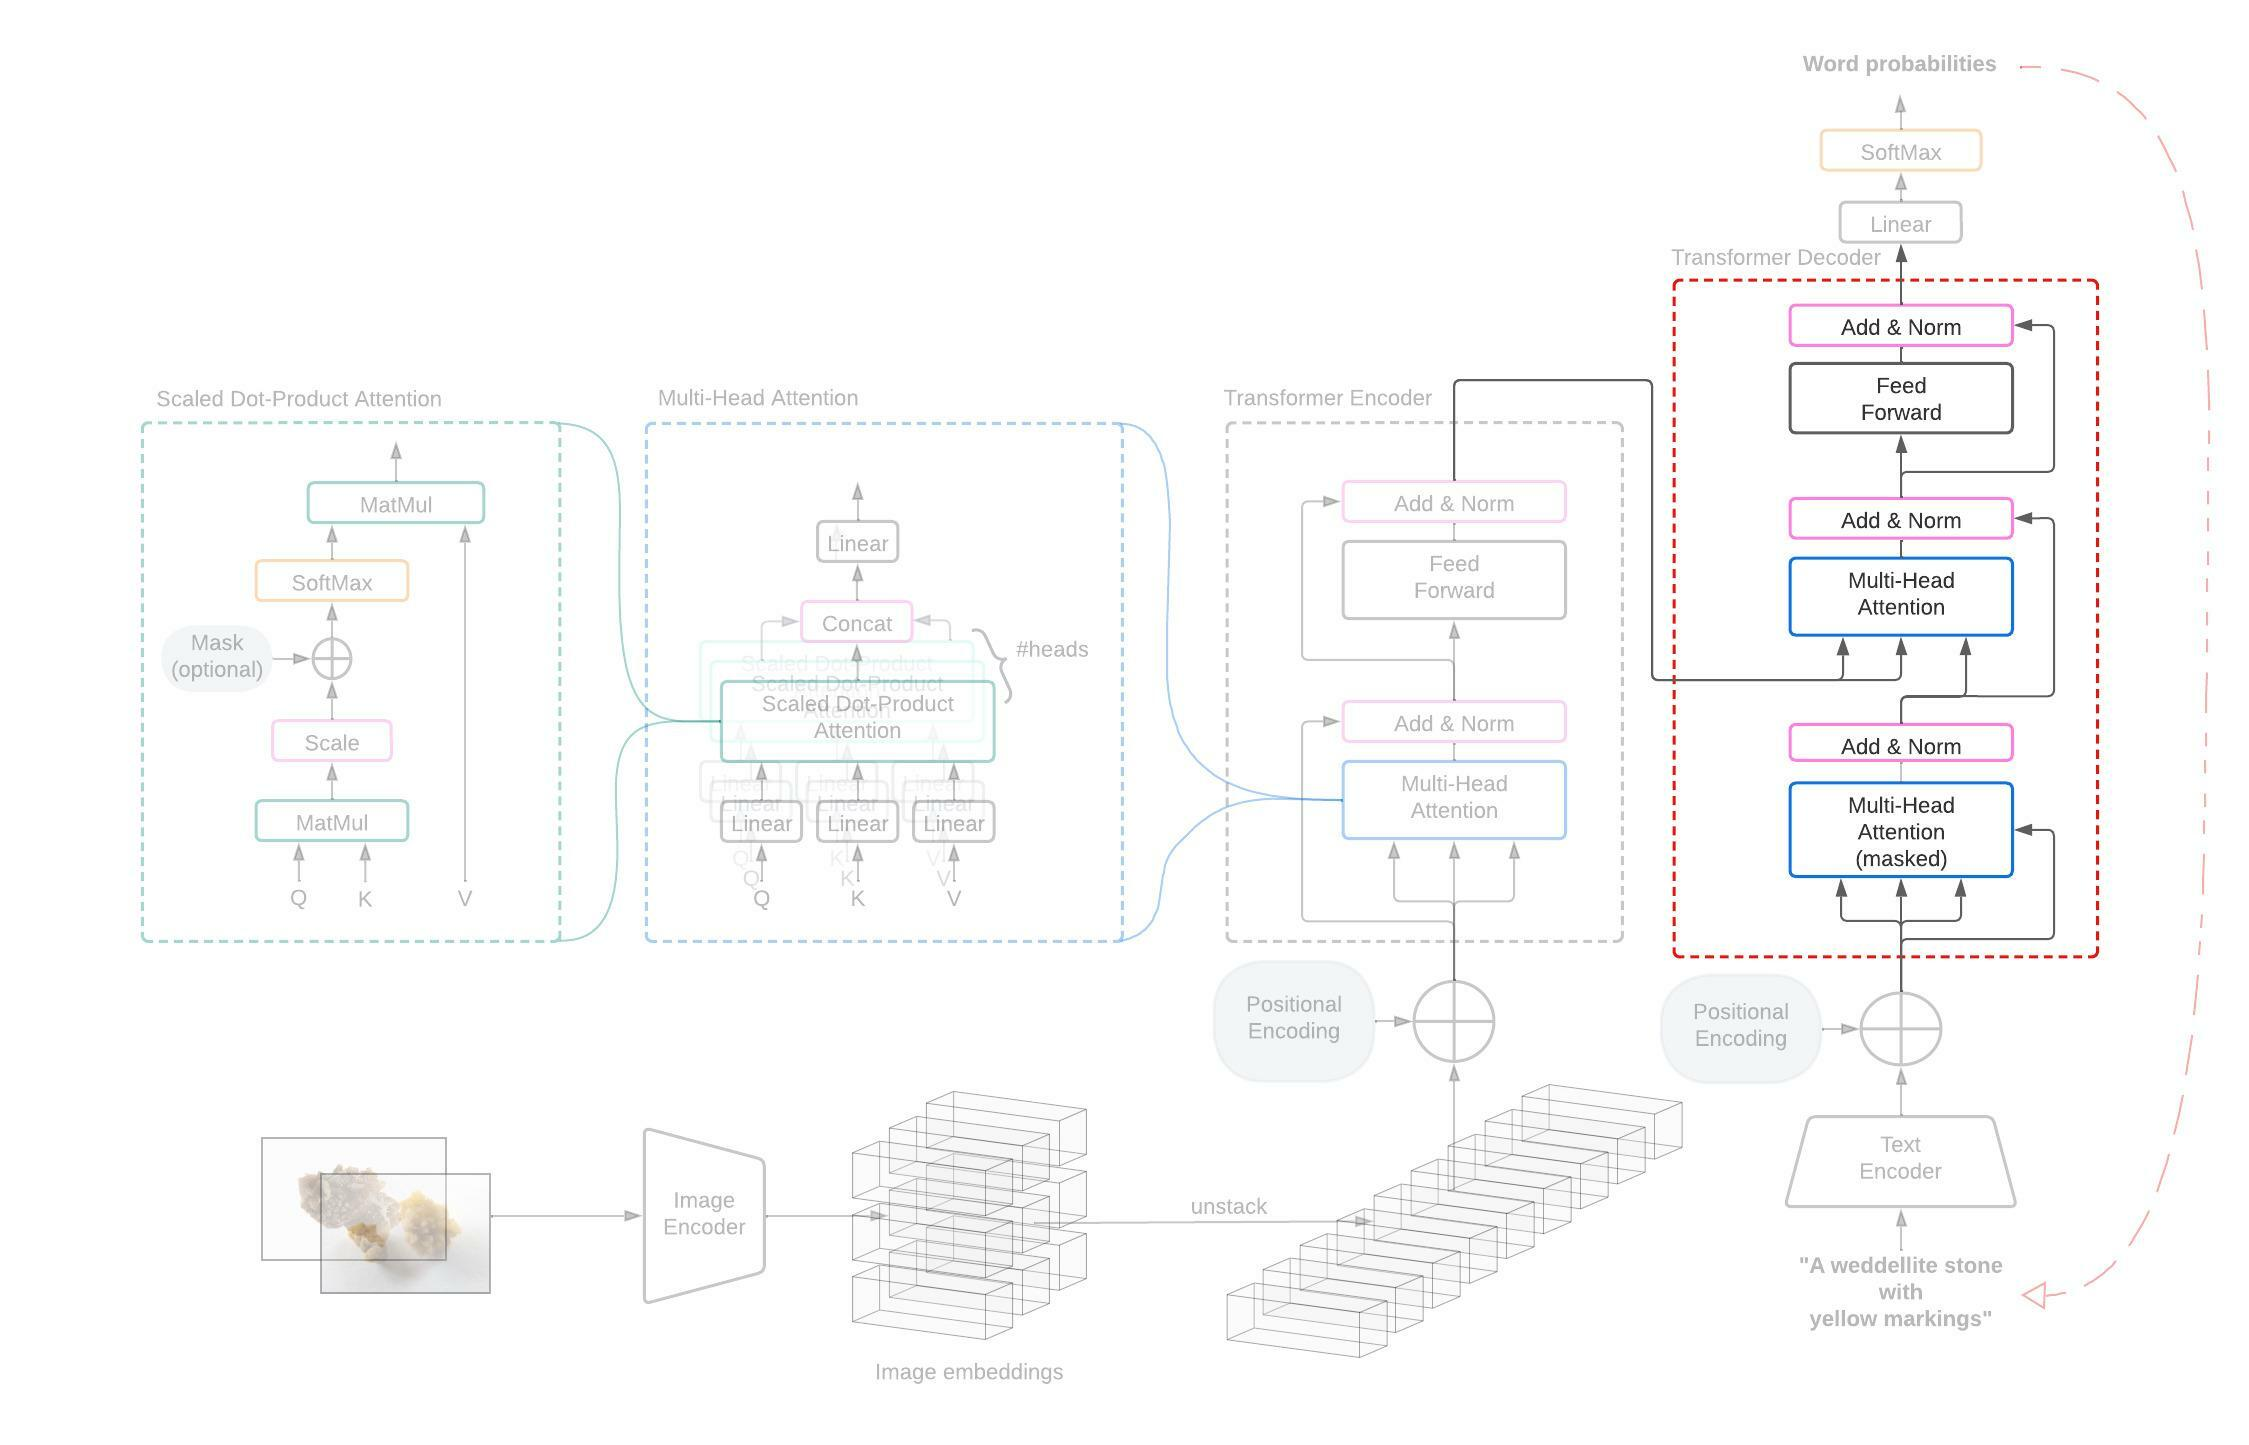

In [ ]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self,num_heads,embedding_dim,dropout,debug=False, **kwargs):
        super().__init__(**kwargs)
        
        self.debug=debug
        
        
        # Multi head attention modules
        self.mha1=MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout)
        self.mha2=MultiHeadAttention(num_heads=num_heads,
                                     key_dim=embedding_dim,
                                     dropout=dropout)
        
        # Layer normalizations
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Feed forward network 
        self.feed_forward = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim,activation='relu'),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(embedding_dim),
            tf.keras.layers.Dropout(dropout)])
        
    def call(self,inputs, image_embedding_sequence, mask=False):
        # Mask the inputs if the option to mask inputs is provided
        debug=self.debug
        if debug:
            print('\n\nTransformer decoder called\n-------------------')
        if debug:
            print('calculating masks ')
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(inputs)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        if debug: 
            print(f'combined mask: {combined_mask.shape}')
        # Pass inputs through first attention head using masking
        if debug:
            print(f'going through attention head 1:\n\t inputs:{inputs.shape}')
        x = self.mha1(
            query=inputs,
            value=inputs,
            key=inputs, 
            attention_mask=combined_mask
            )
        # Add and normalize
        if debug:
            print(f'going thorugh layer normalization 1:\n\t inputs:{inputs.shape}\n\t x:{x.shape}')
        x1=self.layer_norm1(x+inputs)
        
        # Pass inputs throught second attention head
        if debug:
            print(f'going thorugh mha 2: \n\t x1:{x1.shape}\n\t image\
            _embedding_sequence:{image_embedding_sequence.shape}')
        x2=self.mha2(
            query=x1,
            key=image_embedding_sequence,
            value=image_embedding_sequence,
            attention_mask=padding_mask
            
            )
        # Add and normalize
        if debug:
            print(f'going thorugh addnorm2:\n\t x2:{x2.shape}')
        x2=self.layer_norm2(x1+x2)
        
        # Pass inputs through feed forward network
        if debug:
            print(f'going thorugh feed forward:\n\t x2:{x2.shape}')
        x3=self.feed_forward(x2)
        
        # Add and normalize
        if debug:
            print(f'layer normalization:\n\t x2:{x2.shape}\n\t x3:{x3.shape}')
        x3=self.layer_norm3(x2+x3)
        return x3
    
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
        

Test

In [ ]:
# tokenizer_data=data_pipeline['captioning']['train_captions']
# image_input=tf.keras.Input(shape=(299,299,3),name='image')
# text_input= tf.keras.Input(shape=(),dtype=tf.dtypes.string,name='text')


# # Pass text through text encoder
# encoder=MatrixTextEncoder(embedding_dim=300,tokenizer_data=tokenizer_data)
# # Get tokens
# tokens=encoder.tokenize(text_input)
# embeddings=encoder.encode(tokens)
# mask=encoder.mask(tokens)

# # Add positional encoding.
# add_positional_encoding=AddLearntPositional(sequence_length=128,embedding_dim=300)
# text_embeddings=add_positional_encoding(embeddings)

# # Pass image through image encoder. 
# image_encoder=make_image_encoder((299,299), backbone='efficientnetb0',trainable=False)
# image_embeddings=image_encoder(image_input)


# # Go through decoder. 
# decoder= TransformerDecoder(num_heads=2,embedding_dim=300,dropout=0.2,name='decoder')
# prediction_context= decoder(text_embeddings, image_embedding_sequence=image_embeddings, mask=mask)


# model=tf.keras.Model(inputs=[image_input,text_input],outputs=prediction_context)
# emb=model.predict(data_pipeline['captioning']['train'].batch(5).take(3))
# model.summary()


emb

# Captioning Model (Subclassed Model)
Putting it all together in a subclassed model

In [ ]:
class CaptioningTransformer(tf.keras.Model):
    """Makes a transformer based captioning model.

    If the class has public attributes, they may be documented here
    in an ``Attributes`` section and follow the same formatting as a
    function's ``Args`` section. Alternatively, attributes may be documented
    inline with the attribute's declaration (see __init__ method below).

    Properties created with the ``@property`` decorator should be documented
    in the property's getter method.

    Attributes:
        image_size (touple): Height and width of the image taken by the model. 
        
        image_encoder (model): A model that takes images (None, H,W,3) 
            and produces a unstacked convolutional volume (None, positions(HxW) ,emb_length)
        attr2 (:obj:`int`, optional): Description of `attr2`.

    """

    def __init__(self,image_encoder, text_encoder, 
                 transformer_encoder, transformer_decoder,
                 embedding_dim,num_heads,vocab_size,captions_per_image,debug=False,**kwargs):
        super().__init__(**kwargs)
        self.embedding_dim=embedding_dim
        self.image_encoder=image_encoder
        self.image_projector=tf.keras.layers.Dense(embedding_dim)
        self.text_encoder=text_encoder
        self.text_encoder_encoder=text_encoder.encoder
        self.text_enocder_tokenizer=text_encoder.tokenizer
        self.text_projector=tf.keras.layers.Dense(embedding_dim)
        self.seq_len=text_encoder.seq_len
        self.num_heads=num_heads
        self.add_positional_img= AddLearntPositional(image_encoder.output.shape[-2],self.embedding_dim)
        self.add_positional_txt= AddLearntPositional(self.seq_len,self.embedding_dim)
        self.transformer_encoder=transformer_encoder
        self.transformer_decoder=transformer_decoder
        self.vocab_size=vocab_size
        self.debug=debug
        self.captions_per_image=captions_per_image
    
        # The output model, is responsible of taking the decoder sequence output and 
        # translating it to probabilities of the words in the vocab. For now, 
        # it will be a sigmoid with the vocab size. However we may explore other ways 
        # in the future such as distance metrics or similarity between output embeddings and 
        # target wordd embeddings. 
        self.out=tf.keras.layers.Dense(self.vocab_size,activation='softmax')
        
        # Trackers: These 
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
   
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]
    def train_step(self, batch_data):
        debug=self.debug
        # Unpack data 
        if debug:
            print('\n\nCaptioning transformer called\n----------')
        if debug:
            print('unpacking data')
        image_input=batch_data['image']
        text_inputs=batch_data['text']

        batch_acc=0
        batch_loss=0
        for i in range(self.captions_per_image):
            text_input=text_inputs[:,i]
            with tf.GradientTape() as tape:
            # Forward pass
                # Pass text through text encoder
                if debug:
                    print(f'passing text through text encoder:\n\t text_input:{text_input.shape}')

                # Split the predictor text from the target text.
                all_tokens=self.text_encoder.tokenize(text_input)
                predictor_tokens,y_true=all_tokens[:,:-1],all_tokens[:,1:]
                # Get the mask from the targets. 
                
                mask=self.text_encoder.mask(y_true)
                print(f'The mask has dimensions {mask.shape}')

                # Pass image through all image layers
                # (encoding, projection, positional encoding, transformer encoder)
                image_encoding=self.full_encoder(image_input,debug=debug)
                
                # Decode the embeddings using the queries provided by the 
                # predictor tokens.
                y_pred=self.full_decoder(predictor_tokens,image_encoding,mask,debug=debug)

                if debug:
                    print('Calculating loss')
                    print(f'Predictions shape: {y_pred.shape}\ny_true shape{y_true.shape}')

                loss=self.calculate_loss(y_true,y_pred,mask)
                    
            # Compute gradients
            if debug:
                print('computing gradients')
            gradients = tape.gradient(loss, self.trainable_variables)
            
            # Apply gradients
            if debug:
                print('applying weights')
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            # update batch loss
            batch_loss+=loss
            
            # coumpute accuracy and update batch_accuracy
            if debug:
                print('Computing accuracy')
            acc=self.calculate_accuracy(y_true,y_pred,mask)
            batch_acc+=acc
            
        # Update loss trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc/self.captions_per_image)

        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

        
    def full_encoder(self, image_input,debug=False):
        """
        Apply image encoding layers to image input. 
        
        Apply the image encoder, transformer encoder and image projection layers
        to the image. This is known as the "encoder" in the "encoder-decoder" 
        architecture. Notice that it is called "full-encoder" here because it is
        made of several layers. These are: 
        1. Pass image through image encoder. 
        2. Project image encodings to the dimension of the transformer model. 
        3. Pass projected image encodings through transformer encoder. 
        """
        # Pass image through image encoder. 
        if debug:
            print(f'pass through image encoder:\n\t image_input:{image_input.shape}')
        image_embeddings_0=self.image_encoder(image_input)
        # Project image embeddings to right dimension
        image_embeddings_1=self.image_projector(image_embeddings_0)
        # Add positional encoding
        if debug:
            print(f'Adding positional encoder to image embeddings:\n\t image_embeddings: {image_embeddings_1.shape}')
        image_embeddings_2=self.add_positional_img(image_embeddings_1)

        # Pass image encoder outputs through transformer encoder
        image_embeddings_3=self.transformer_encoder(image_embeddings_2)['embeddings']
        return image_embeddings_3
        
    def full_decoder(self,predictor_tokens,image_embeddings,mask,debug=False):
        """
        Decode the predictor_tokens and the image_embeddings into the
        predictions for words at each slot in the target. 
        
        Args: 
            predictor_tokens: The left part of the training sequence used to 
                predict the right part of the sequence. It must already be 
                tokenized.
            image_embeddings: The result of the full_encoding process of the 
                image. 
            mask: Masking of the empty tokens of the target sequence.
        Returns:
            probs: The probabilities for every word in the output sequence. 
                Probs have shape (None,seq_len,vocab_size)
        """
        # Use text encoder to get embeddings from tokens. 
        token_embeddings=self.text_encoder.encode(predictor_tokens)
        # Project text encodings to right shape for transformer
        if debug:
            print(f'going thorugh text_projector:\n\t embeddings:{token_embeddings.shape}')
        token_embeddings=self.text_projector(token_embeddings)
        # Add positional encoding.
        if debug: 
            print(f'adding positional embeddings to text \n\t embeddings:{token_embeddings.shape}')
        queries=self.add_positional_txt(token_embeddings)
        
         # Go through transformer decoder. 
        if debug:
            print(f'going through decoder\n\t image_embedding_sequence:{image_embeddings.shape}'+
                  f'\n\t text_embedings:{queries.shape} ')
        prediction_context= self.transformer_decoder(queries, 
                                                     image_embedding_sequence=image_embeddings, 
                                                     mask=mask)
        # Compute loss.
        probs=self.out(prediction_context)
        return probs
    
    def calculate_loss(self, y_true, y_pred, mask):
        """
        Calculates the loss and masks it 
        
        Args:
        y_true: Batch of tokens with dimension (None,seq_len-1)
            (-1 because of the left shifting of the input sequence)
        y_pred: A batch of probabilities
        
        """
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        loss= (tf.reduce_sum(loss) / tf.reduce_sum(mask))
        # if math.isnan(loss):
        #     print('loss is nan')
        #     print(f'mask:\n {tf.reduce_sum(mask)}')
        #     print(f'y_true:\n {y_true}')
        #     print(f'y_pred:\n {y_pred}')
        
        return loss
    
    def calculate_accuracy(self, y_true, y_pred, mask):
        # Argmax get's the index of the max across the vocabulary dimension. 
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        
        # The logical and avoids counting correct 
        # predictions of values that are masked
        accuracy = tf.math.logical_and(mask, accuracy)
        
        # Ture values are casted to 1. 
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    def test_step(self,batch_data):
        debug=self.debug
        # Unpack data 
        if debug:
            print('\n\nCaptioning transformer called\n----------')
        if debug:
            print('unpacking data')
        image_input=batch_data['image']
        text_inputs=batch_data['text']

        batch_acc=0
        batch_loss=0
        for i in range(self.captions_per_image):
            text_input=text_inputs[:,i]
            # Forward pass
            # Pass text through text encoder
            if debug:
                print(f'passing text through text encoder:\n\t text_input:{text_input.shape}')

            # Split the predictor text from the target text.
            all_tokens=self.text_encoder.tokenize(text_input)
            predictor_tokens,y_true=all_tokens[:,:-1],all_tokens[:,1:]
            # Get the mask from the targets. 
            mask=self.text_encoder.mask(y_true)

            # Pass image through all image layers
            # (encoding, projection, positional encoding, transformer encoder)
            image_encoding=self.full_encoder(image_input,debug=debug)

            # Decode the embeddings using the queries provided by the 
            # predictor tokens.
            y_pred=self.full_decoder(predictor_tokens,image_encoding,mask,debug=debug)

            if debug:
                print('Calculating loss')
                print(f'Predictions shape: {y_pred.shape}\ny_true shape{y_true.shape}')

            loss=self.calculate_loss(y_true,y_pred,mask)
                                 
            # update batch loss
            batch_loss+=loss
            
            # coumpute accuracy and update batch_accuracy
            if debug:
                print('Computing accuracy')
            acc=self.calculate_accuracy(y_true,y_pred,mask)
            batch_acc+=acc
            
        # Update loss trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc/self.captions_per_image)

        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}
        
    
#         def next_word(self,img,generated_caption='<start> '):
#             """
#             Takes the generated caption as an image then generates next word in caption. 
            
#             Args: 
#                 generated_caption(str, optional): The generated caption so far. 
#                     if nothing is privided then a new caption is started with 
#                     the start token '<start> '. 
#                 img(int array): The image must have shape (299,299,3) and range 
#                     between 0 and 255 in values. 
#             Returns: 
#                 next_word(str): The next word in the caption. 
                
                
#             """


## Examples on accuracy and loss function

In [ ]:
 def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

In [ ]:

def calculate_loss(loss, y_true, y_pred, mask):
        loss = loss(y_true, y_pred)
        print('loss before mask')
        print(loss)
        mask = tf.cast(mask, dtype=loss.dtype)
        
        loss *= mask
        print('loss after mask')
        print(loss)
        print('numerator')
        print(tf.reduce_sum(loss))
        print('denominator')
        print(tf.reduce_sum(mask))
        
        return tf.reduce_sum(loss) / (tf.reduce_sum(mask))

In [ ]:
y_true=np.array([[0,1,2],
                 [2,1,0]])

y_pred=np.array([0.01,0.2,0,
                 0,1,0,
                 0,0,1,
                 
                 0,0,1,
                 0,1,0,
                 0.9,0,0]).reshape(2,3,3)
mask=np.array([[1,1,0],[1,0,0]])
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

In [ ]:
print(y_pred)
print(y_true)

[[[0.01 0.2  0.  ]
  [0.   1.   0.  ]
  [0.   0.   1.  ]]

 [[0.   0.   1.  ]
  [0.   1.   0.  ]
  [0.9  0.   0.  ]]]
[[0 1 2]
 [2 1 0]]


In [ ]:
tf.argmax(y_pred,axis=2)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 1, 2],
       [2, 1, 0]])>

In [ ]:
tf.equal(y_true, tf.argmax(y_pred, axis=2))

<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[False,  True,  True],
       [ True,  True,  True]])>

In [ ]:
calculate_loss(loss,y_true,y_pred,mask)

loss before mask
tf.Tensor(
[[3.04452300e+00 2.00000002e-07 2.00000002e-07]
 [2.00000002e-07 2.00000002e-07 2.22222198e-07]], shape=(2, 3), dtype=float64)
loss after mask
tf.Tensor(
[[3.04452300e+00 2.00000002e-07 0.00000000e+00]
 [2.00000002e-07 0.00000000e+00 0.00000000e+00]], shape=(2, 3), dtype=float64)
numerator
tf.Tensor(3.0445234007171678, shape=(), dtype=float64)
denominator
tf.Tensor(3.0, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=1.0148411335723893>

# Training test

## Instantiate Model

In [ ]:

#Settings
#IMG encoder settings

params={
    'IMG_SIZE':(299,299),
    'IMG_BACKBONE':'efficientnetb0',
    'IMG_TRAINABLE':False,
    'EMBEDDIN[_DIM':100,
    'SEQ_LEN':70 ,
    'NUM_HEADS':3,
    'DROPOUT':0.01,
    'DATA_PATH':'../data/intermediate/inter_medpix.csv',
    'DATA_SPLIT':[0.9,0.05,0.05],
    'DATA_DOWNSCALE':False,
    'DATA_SHUFFLE':True,
    'DATA_SHUFFLE_SEED':1,
    'LOSS':tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False),
    'OPTIMIZER': keras.optimizers.Adam(learning_rate=9e-4),
    'LEARNING_RATE': 9e-4,
}
# No downscaling to keep values between 0 and 255 so that efficientnetb0 can take them. 
data_pipeline=make_pipeline(params['DATA_PATH'],params['DATA_DOWNSCALE'],fractions=params['DATA_SPLIT'))

tokenizer_data=data_pipeline['captioning']['train_captions']

image_encoder=make_image_encoder(params['IMG_SIZE'], backbone=params['IMG_BACKBONE'],trainable= params['IMG_TRAINABLE'])


text_encoder=MatrixTextEncoder(seq_len=params['SEQ_LEN'],embedding_dim=params['EMBEDDING_DIM'],tokenizer_data=tokenizer_data,
                               projection_trainable=True,
                               backbone_trainable=True)
VOCAB_SIZE=text_encoder.vocabulary_size


transformer_encoder=TransformerEncoder(params['SEQ_LEN'], params['EMBEDDING_DIM'], params['NUM_HEADS'], params['DROPOUT'])
transformer_decoder=TransformerDecoder(params['NUM_HEADS'],params['EMBEDDING_DIM'],params['DROPOUT'])


model=CaptioningTransformer(image_encoder, text_encoder, 
                 transformer_encoder, transformer_decoder, params['EMBEDDING_DIM'],
                 params['NUM_HEADS'],VOCAB_SIZE,captions_per_image=1)

making input pipeline


ValueError: in user code:

    File "/home/jupyter/MedClip/src/preprocess/pipelines.py", line 127, in None  *
        lambda x: decode_and_resize(x,scale_val),
    File "/home/jupyter/MedClip/src/preprocess/pipelines.py", line 104, in decode_and_resize  *
        img = tf.image.resize(img, image_size)

    ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width


## Define callbacks

In [ ]:
# Define checkpoints path
date_str=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_model_path='../models/pretraining/captioning/' + date_str + "medpix"

# Define logs path
logs='../model_logs/pretraining/captioning/'

# Define callbacks
# Since model is subclassed we save weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_model_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

tensorboard_callback=tf.keras.callbacks.TensorBoard(
    log_dir=logs+date_str,
    histogram_freq=None,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=1,
    embeddings_metadata=None)



# Define learning rate decay 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-7,
    decay_steps=8,
    decay_rate=1.5)
    



class CaptioningCallback(tf.keras.callbacks.Callback):
    """ A callback to be used when training a captioning model. 
    
    The callback includes hyperparameter logging with all information necessary
    to recreate the model as well as logging pictures with captions and the 
    bleu metrics. 
    
    
    """
    def __init__(self,eval_dataset,eval_img_paths,model_params,log_dir):
        """
        Args:
            eval_img_paths(list of str): The paths to images for high quality logging. 
            eval_dataset(tensorflow dataset): The dataset to be used for evaluation. 
                it should have matching order to that of the eval_img paths. 
            model_params (dict): Parameter dictionary for the current model. 
                it contains all the information of the model such as the dataset
                it is trained on and dropout, size, etc. 
            log_dir
        """
        
        super().__init__()
        self.eval_data = eval_dataset
        self.eval_img_paths= eval_img_paths
        self.model_params=model_params
        self.log_dir=log_dir
    def on_train_begin(self,logs=None):
        """
        Log the model parameters and name of the training dataset. 

        """
        file_writer = tf.summary.create_file_writer(log_dir) #+ "/model_params")
        file_writer.set_as_default()
        tf.summary.text("model_params", pretty_json(self.model_params), step=0)
    def on_epoch_end(self, epoch,logs):
        ''' 
        Log bleu metrics
        '''
        file_writer = tf.summary.create_file_writer(self.log_dir) #+ "/metrics")
        file_writer.set_as_default()
        
        # if epoch%2==0:
        #     print('\n saving epoch checkpoint for img and text encoders')
        #     # img_encoder.save(image_encoder_savepath + '/epoch_'+str(epoch))
        #     # txt_encoder.save(text_encoder_savepath + + '/epoch_'+str(epoch) )
        # print('\nevaluating eppoch retrieval')
        # acc=top_k_accuracy(img_encoder,txt_encoder,self.eval_img_paths,self.eval_queries,k=self.top_k_k,batch_size=32)
        # tf.summary.scalar('top_'+str(self.top_k_k)+'_accuracy', acc, step=epoch)

        

## Compile and Train

In [ ]:
log_path='../model_logs/pretraining/captioning'

In [ ]:
%load_ext tensorboard

In [ ]:
train_data=data_pipeline['captioning']['train'].batch(32)
validation_data=data_pipeline['captioning']['val'].batch(32)
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = keras.optimizers.Adam(learning_rate=params['LEARNING_RATE'])
model.compile(loss=loss, optimizer=opt)
model.fit(train_data,validation_data=validation_data,epochs=200,callbacks=[checkpoint_callback,tensorboard_callback])
# model.fit(train_data.take(10),
#           validation_data=validation_data.take(5),
#           epochs=20,callbacks=[checkpoint_callback,tensorboard_callback])

# Saving and loading
We instantiate a model, train it, save weights and then load it again 

In [ ]:
# Instantiate a model

#Settings
#IMG encoder settings
IMG_SIZE=(299,299)
IMG_BACKBONE='efficientnetb0'
IMG_TRAINABLE=False
EMBEDDING_DIM=200
SEQ_LEN=70 
NUM_HEADS=10
DROPOUT=0.01
TXT_TRAINABLE=True 

params={
    'IMG_SIZE':(299,299),
    'IMG_BACKBONE':'efficientnetb0',
    'IMG_TRAINABLE':False,
    'EMBEDDING_DIM':800,
    'SEQ_LEN':70 ,
    'NUM_HEADS':3,
    'DROPOUT':0.01,
    'TXT_TRAINABLE':True,
    'DATA_PATH':'../data/intermediate/inter_medpix.csv',
    'DATA_SPLIT':[0.9,0.05,0.05],
    'DATA_SHUFFLE':True,
    'DATA_SHUFFLE_SEED':1,
    'LOSS':tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False),
    'OPTIMIZER': keras.optimizers.Adam(learning_rate=9e-4),
    'LEARNING_RATE': 9e-4

}





# No downscaling to keep values between 0 and 255 so that efficientnetb0 can take them. 
data_pipeline=make_pipeline('../data/intermediate/inter_medpix.csv', # Instantiate pipeline for data
                  image_size=(299, 299),downscale=False,
                  shuffle=True,
                  seed=1,fractions=[0.90,0.05,0.05]) 

tokenizer_data=data_pipeline['captioning']['train_captions'] # prepared data for tokenizer instantiation





# Instantiate model parameters

image_encoder=make_image_encoder(IMG_SIZE, backbone=IMG_BACKBONE,trainable=IMG_TRAINABLE)


text_encoder=MatrixTextEncoder(seq_len=SEQ_LEN,embedding_dim=EMBEDDING_DIM,tokenizer_data=tokenizer_data,
                               projection_trainable=TXT_TRAINABLE,
                               backbone_trainable=TXT_TRAINABLE)
VOCAB_SIZE=text_encoder.vocabulary_size


transformer_encoder=TransformerEncoder(SEQ_LEN, EMBEDDING_DIM, NUM_HEADS, DROPOUT)
transformer_decoder=TransformerDecoder(NUM_HEADS,EMBEDDING_DIM,DROPOUT)


model=CaptioningTransformer(image_encoder, text_encoder, 
                 transformer_encoder, transformer_decoder, EMBEDDING_DIM,
                 NUM_HEADS,VOCAB_SIZE,captions_per_image=1)

# instantiate the model and fit it for 100 eppochs
train_data=data_pipeline['captioning']['train'].batch(1).take(1)
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = keras.optimizers.Adam(learning_rate=9e-4)
model.compile(loss=loss, optimizer=opt)
model.fit(train_data,epochs=3)

In [ ]:
# save the model weights
model.save_weights('./model_logs/pretraining/captioning', save_format='tf')
history_before=model.fit(train_data,epochs=1)

In [ ]:
## Load a model

In [ ]:


image_encoder=make_image_encoder(IMG_SIZE, backbone=IMG_BACKBONE,trainable=IMG_TRAINABLE)


text_encoder=MatrixTextEncoder(seq_len=SEQ_LEN,embedding_dim=EMBEDDING_DIM,tokenizer_data=tokenizer_data,
                               projection_trainable=TXT_TRAINABLE,
                               backbone_trainable=TXT_TRAINABLE)
VOCAB_SIZE=text_encoder.vocabulary_size


transformer_encoder=TransformerEncoder(SEQ_LEN, EMBEDDING_DIM, NUM_HEADS, DROPOUT)
transformer_decoder=TransformerDecoder(NUM_HEADS,EMBEDDING_DIM,DROPOUT)


new_model=CaptioningTransformer(image_encoder, text_encoder, 
                 transformer_encoder, transformer_decoder, EMBEDDING_DIM,
                 NUM_HEADS,VOCAB_SIZE,captions_per_image=1)

# Compile and fit model in 1 batch
# instantiate the model and fit it for 100 eppochs
loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = keras.optimizers.Adam(learning_rate=9e-4)
new_model.compile(loss=loss, optimizer=opt)
new_model.fit(train_data,epochs=1)

# Load the weights
new_model.load_weights('./tests/path_to_my_weights')

In [ ]:
# See if history is the same
history_after=new_model.fit(train_data,epochs=1)

In [ ]:
history_before.history

In [ ]:
history_after.history

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../model_logs/pretraining/captioning/

# Make captions for the test set

In [ ]:
# # Remember to create the object model and call it on some data fist
# path='../models/pretraining/captioning/20220814-170749' 
# model.load_weights(path)
def test_step(batch_data,self=model):
        debug=self.debug
        # Unpack data 
        if debug:
            print('test_step')
            print('\n\nCaptioning transformer called\n----------')
        if debug:
            print('unpacking data')
        image_input=batch_data['image']
        text_input=batch_data['text']
        
        # Forward pass
        # Pass text through text encoder
        if debug:
            print(f'passing text through text encoder:\n\t text_input:{text_input.shape}')


        # Split the predictor text from the target test. 
        all_tokens=self.text_encoder.tokenize(text_input)
        predictor_tokens,y_true=all_tokens[:,:-1],all_tokens[:,1:]
        mask=self.text_encoder.mask(predictor_tokens)
        embeddings=self.text_encoder.encode(predictor_tokens)

        # Project text encodings to right shape
        if debug:
            print(f'going thorugh text_projector:\n\t embeddings:{embeddings.shape}')
        embeddings=self.text_projector(embeddings)

        # Add positional encoding.
        if debug: 
            print(f'adding positional embeddings to text \n\t embeddings:{embeddings.shape}')
        text_embeddings=self.add_positional_txt(embeddings)

        # Pass image through image encoder. 
        if debug:
            print(f'pass through image encoder:\n\t image_input:{image_input.shape}')
        image_embeddings_0=self.image_encoder(image_input)
        # Project image embeddings to right dimension
        image_embeddings_1=self.image_projector(image_embeddings_0)

        # Add positional encoding
        if debug:
            print(f'Adding positional encoder to image embeddings:\n\t image_embeddings: {image_embeddings.shape}')
        image_embeddings_2=self.add_positional_img(image_embeddings_1)

        # Pass image encoder outputs through transformer encoder
        image_embeddings_3=self.transformer_encoder(image_embeddings_2)['embeddings']


        # Go through decoder. 
        if debug:
            print(f'going through decoder\n\t image_embedding_sequence:{image_embeddings.shape}'+
                  f'\n\t text_embedings:{text_embeddings.shape} ')
        prediction_context= self.transformer_decoder(text_embeddings, 
                                                     image_embedding_sequence=image_embeddings_3, 
                                                     mask=mask)
        # Compute loss.
        y_pred=self.out(prediction_context)
        return y_pred

In [ ]:
def format_original(messy_string,width=60):
    caption=messy_string.numpy()[0][0].decode("utf-8")
    caption=caption.replace('<start> ','')
    caption=caption.replace('Modality: ','Modality:\n')
    caption=caption.replace(' Anatomy: ','\n\nAnatomy:\n')
    caption=caption.replace('Impression: ','\n\nImpression:\n')
    caption=caption.replace('Findings: ','\n\nFindings:\n')
    caption = re.sub(r"<end>(.*)", " ", caption)
    # Wrapping
    wrapper = textwrap.TextWrapper(width=width)
    caption = wrapper.fill(text=caption) 
    return caption
    

In [ ]:
def format_caption(messy_string,width=60): 
    caption=messy_string.numpy()[0].decode("utf-8")
    caption=caption.replace('<start> ','')
    caption=caption.replace(' modality ','Modality:\n')
    caption=caption.replace(' anatomy ','\n\nAnatomy:\n')
    caption=caption.replace('impression ','\n\nImpression:\n')
    caption=caption.replace('findings ','\n\nFindings:\n')
    caption=caption.replace(' •',' \n•')
    caption = re.sub(r"<end>(.*)", " ", caption)
    # Wrapping 
    wrapper = textwrap.TextWrapper(width=width)
    caption = wrapper.fill(text=caption)
    return caption
    

In [ ]:
# Prepare images from test set to be captioned
imgs=[]
texts=[]
for i in data_pipeline['captioning']['test'].take(3):
    img=i['image']
    text=i['text']
    imgs.append(img)
    texts.append(text)
    
    
# Caption them
true_captions=[]
true_tokens = []
predicted_captions= []
predicted_tokens = []

modality='US' #<--- select modality here
print('--------\n')
print('searching for {US}')
for i in tqdm(range(len(imgs))):
    # Check if the image is of a certain modality
                                                      
    
    
    img=imgs[i]
    img=tf.expand_dims(img,0)
    text=texts[i]
    text=tf.expand_dims(text,0)
    original=format_original(text)
 
    
    tokens=model.text_encoder.tokenize(text)
    true_tokens.append(tokens)

    batch_data={'image':img,'text':tf.constant('<start> ', shape=(1,))}

    this_tokens=[]
    for i in range(49):
        this_tokens
        
        probs=test_step(batch_data)
        selection=np.argmax(probs,axis=-1)
        
        this_tokens.append(selection[0,i])
        word=model.text_encoder.vocabulary_dict[selection[0,i]]
        batch_data['text']=batch_data['text']+' '+word

    predicted_tokens.append(this_tokens)
    plt.figure()
    plt.imshow(img.numpy()[0].astype(int))
    plt.show()
    print('ORIGINAL ----------------')
    print(original)
    print('\n')
    print('AI GENERATED ------------')
    caption=format_caption(batch_data['text'])
    print(caption)



    predicted_captions.append(caption)
    true_captions.append(text[0][0].numpy().decode("utf-8"))


In [ ]:
true_tokens=[list(tokens.numpy()[0]) for tokens in true_tokens]

In [ ]:
true_captions=[caption[8:-6] for caption in true_captions]

In [ ]:
# save the resulting captions to a csv
import pandas as pd
import os
d={'true':true_captions,'predicted':predicted_captions}
results=pd.DataFrame(d)
os.makedirs(f'../results/{date_str}/',exist_ok=True)
results.to_csv(f'../results/{date_str}/results_100.csv', index=False)

# How are captions generated?

In [ ]:

# i=0
# img=imgs[i]
# text=texts[i]


# # Show image and text
# plt.imshow(img.numpy().astype(int))
# print(text)
# img=tf.expand_dims(img,0)

# # Image encoding-->Projection-->Positional-->TransformerEncoder-->
# #--------------------------------------------------------------
# # Pass through image_encoder
# encoded_img = model.image_encoder(img, training=False)
# # Pass through projector
# proj_img=model.image_projector(encoded_img,training=False)
# # Add positional encoding
# positional_img=model.add_positional_img(proj_img,training=False)
# # Pass through transformer encoder
# t_img= model.transformer_encoder(positional_img,training=False)['embeddings']

# # Caption-->tokenize-->encode-->project-->mask
# # ----------------------------------------
# capt=['<start>']
# max_length_caption=99

# # Now inside a for loop: 
# for i in range(69):
#     # print(f'Round: {i}')
#     tokenized_capt=model.text_encoder.tokenize(capt)[:,:-1]
#     print(f'caption: {capt}')
#     print(tokenized_capt)
#     mask=model.text_encoder.mask(tokenized_capt)
#     capt_encoding=model.text_encoder.encode(tokenized_capt,training=False)
#     capt_proj=model.text_projector(capt_encoding,training=False)
#     # (capt_proj,img_transformer_encoding)-->TransformerDecoder-->Ouptut-->pred
#     # -----------------------------------------------------------------------------
# #     print('img encoding',np.linalg.norm(t_img.numpy()))
# #     print('text encoding',np.linalg.norm(capt_proj.numpy()))
          
#     context=model.transformer_decoder(capt_proj,t_img,mask=mask,training=False)
#     # print(context)
#     probs=model.out(context)
#     # print(f'probs shape: {probs.shape}')
#     selection=np.argmax(probs[0,i,:])
#     # print(f'the selection is {selection} which translates to {model.text_encoder.vocabulary_dict[selection]}')
    
#     word=model.text_encoder.vocabulary_dict[selection]
# #     print(word)
#     capt[0]= capt[0] +' ' + word
#     # print(f'caption at end of loop is {capt}')
    
# print(capt)

# # # -----------------------------------------------------
# # for i in tf.argmax(probs,axis=2).numpy()[0]:
# #     print(model.text_encoder.vocabulary_dict[i])



# Check tensorboard

In [ ]:
%load_ext tensorboard 

In [ ]:
logdir='../model_logs/pretraining/captioning/'

In [ ]:
%tensorboard --logdir {logdir}

## Load a model (prepare model calling on dummy data) 

In [ ]:
from preprocess.pipelines import make_pipeline
import os
os.environ['TENSORBOARD_BINARY'] = '../venv/bin/tensorboard'

In [ ]:
# Insantiate the dataset
# No downscaling to keep values between 0 and 255 so that efficientnetb0 can take them. 
data_pipeline=make_pipeline('../data/intermediate/inter_medpix.csv',downscale=False,fractions=[0.9,0.05,0.05])
train_data=data_pipeline['captioning']['train'].batch(32)
validation_data=data_pipeline['captioning']['val'].batch(32)

In [ ]:
# Instantiate the model

#Settings
#IMG encoder settings
IMG_SIZE=(299,299)
IMG_BACKBONE='efficientnetb0'
IMG_TRAINABLE=False
EMBEDDING_DIM=728
SEQ_LEN=70 
NUM_HEADS=10
DROPOUT=0.01
TXT_TRAINABLE=True 

params={
    'IMG_SIZE':(299,299),
    'IMG_BACKBONE':'efficientnetb0',
    'IMG_TRAINABLE':False,
    'EMBEDDING_DIM':728,
    'SEQ_LEN':70 ,
    'NUM_HEADS':3,
    'DROPOUT':0.01,
    'TXT_TRAINABLE':True,
    'DATA_PATH':'../data/intermediate/inter_medpix.csv',
    'DATA_SPLIT':[0.9,0.05,0.05],
    'DATA_DOWNSCALE':False,
    'DATA_SHUFFLE':True,
    'DATA_SHUFFLE_SEED':1,
    'LOSS':tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False),
    'OPTIMIZER': keras.optimizers.Adam(learning_rate=9e-4),
    'LEARNING_RATE': 9e-4,
    'CAPTIONS_PER_IMG': 5

}


tokenizer_data=data_pipeline['captioning']['train_captions']
# Need to edit projection head to make it fixed


image_encoder=make_image_encoder(IMG_SIZE, backbone=IMG_BACKBONE,trainable=IMG_TRAINABLE)


text_encoder=MatrixTextEncoder(seq_len=SEQ_LEN,embedding_dim=EMBEDDING_DIM,tokenizer_data=tokenizer_data,
                               projection_trainable=TXT_TRAINABLE,
                               backbone_trainable=TXT_TRAINABLE)
VOCAB_SIZE=text_encoder.vocabulary_size


transformer_encoder=TransformerEncoder(SEQ_LEN, EMBEDDING_DIM, NUM_HEADS, DROPOUT)
transformer_decoder=TransformerDecoder(NUM_HEADS,EMBEDDING_DIM,DROPOUT)


model=CaptioningTransformer(image_encoder, text_encoder, 
                 transformer_encoder, transformer_decoder, EMBEDDING_DIM,
                 NUM_HEADS,VOCAB_SIZE,captions_per_image=1)

# Call on some data



loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',from_logits=False)
opt = keras.optimizers.Adam(learning_rate=9e-4)
model.compile(loss=loss, optimizer=opt)
model.fit(train_data.take(1))




In [ ]:
# Load the weights
model.load_weights('../models/pretraining/captioning/20221029-172847') 